In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 5
DATASET_VERSION = "06"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-xtree-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-xtree-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-xtree-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
!ls ../data/processed/dsv02

test.parquet  train.parquet


In [6]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [7]:
input_feats = train.columns.tolist()
len(input_feats)

1308

In [8]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [9]:
model_params = {
    'boosting':'dart',
    'extra_trees':True,
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.2,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [10]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        seed = repetition*5 + fold
        _model_params = dict(model_params)
        _model_params["seed"] = seed
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        print("seed:", seed)
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        model = lgb.train(
            params=_model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=5000,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [11]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/5 ################################
######################################## training model 1/5 ########################################
seed: 0
[50]	valid_0's amex_metric: 0.747073	valid_0's recall_at4: 0.594883	valid_0's norm_gini: 0.899262
[100]	valid_0's amex_metric: 0.75753	valid_0's recall_at4: 0.610662	valid_0's norm_gini: 0.904397
[150]	valid_0's amex_metric: 0.762962	valid_0's recall_at4: 0.618741	valid_0's norm_gini: 0.907184
[200]	valid_0's amex_metric: 0.767327	valid_0's recall_at4: 0.625305	valid_0's norm_gini: 0.909349
[250]	valid_0's amex_metric: 0.76906	valid_0's recall_at4: 0.62703	valid_0's norm_gini: 0.911089
[300]	valid_0's amex_metric: 0.771454	valid_0's recall_at4: 0.630649	valid_0's norm_gini: 0.91226
[350]	valid_0's amex_metric: 0.773292	valid_0's recall_at4: 0.633173	valid_0's norm_gini: 0.91341
[400]	valid_0's amex_metric: 0.776115	valid_0's recall_at4: 0.637928	valid_0's norm_gini: 0.914301
[450

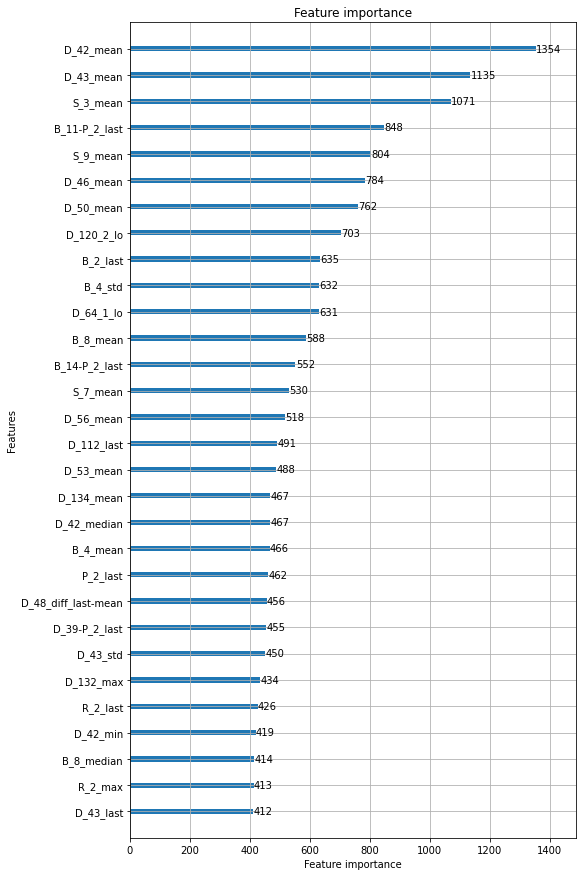

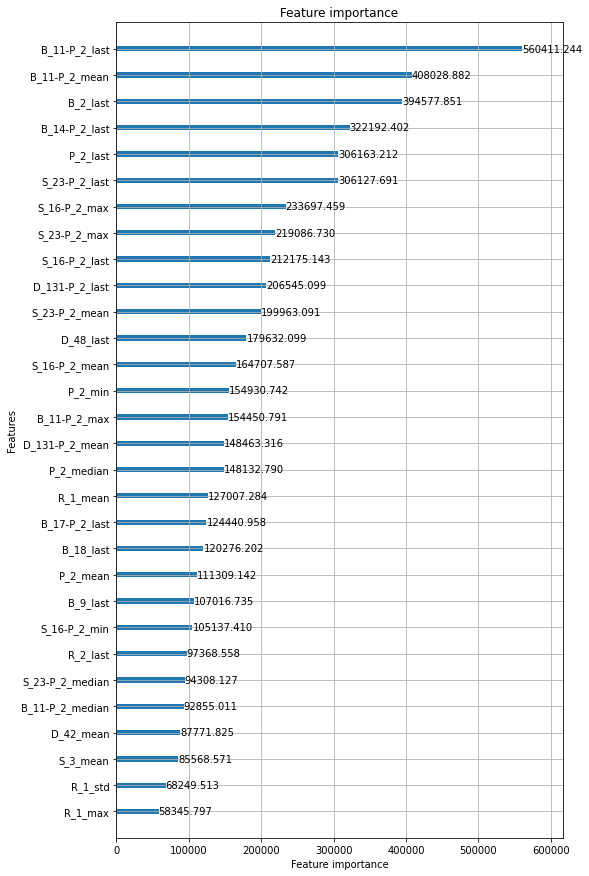

######################################## training model 2/5 ########################################
seed: 1
[50]	valid_0's amex_metric: 0.749069	valid_0's recall_at4: 0.597745	valid_0's norm_gini: 0.900392
[100]	valid_0's amex_metric: 0.757451	valid_0's recall_at4: 0.610031	valid_0's norm_gini: 0.904871
[150]	valid_0's amex_metric: 0.762124	valid_0's recall_at4: 0.617184	valid_0's norm_gini: 0.907064
[200]	valid_0's amex_metric: 0.765106	valid_0's recall_at4: 0.621224	valid_0's norm_gini: 0.908989
[250]	valid_0's amex_metric: 0.767145	valid_0's recall_at4: 0.623832	valid_0's norm_gini: 0.910457
[300]	valid_0's amex_metric: 0.771476	valid_0's recall_at4: 0.630649	valid_0's norm_gini: 0.912303
[350]	valid_0's amex_metric: 0.772975	valid_0's recall_at4: 0.632837	valid_0's norm_gini: 0.913114
[400]	valid_0's amex_metric: 0.77488	valid_0's recall_at4: 0.635404	valid_0's norm_gini: 0.914357
[450]	valid_0's amex_metric: 0.777231	valid_0's recall_at4: 0.63877	valid_0's norm_gini: 0.915691
[50

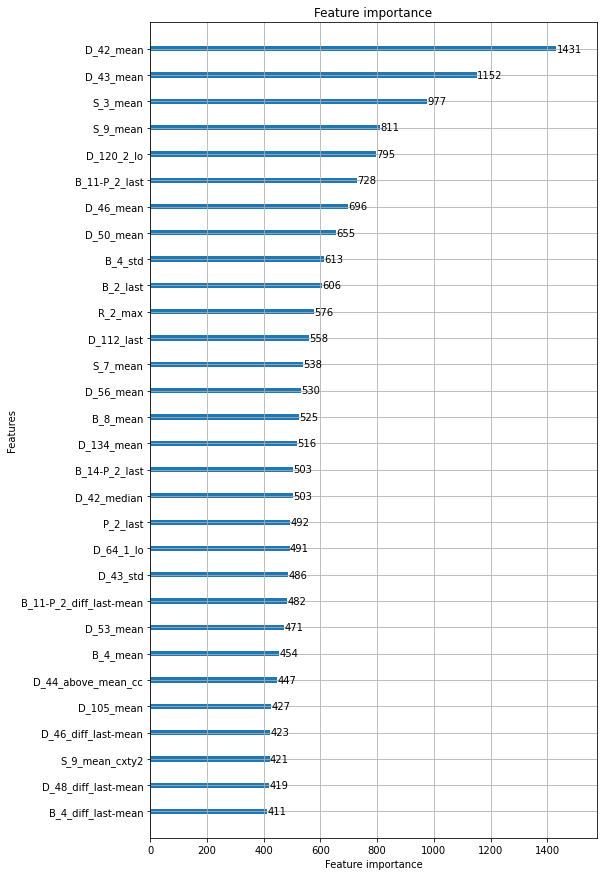

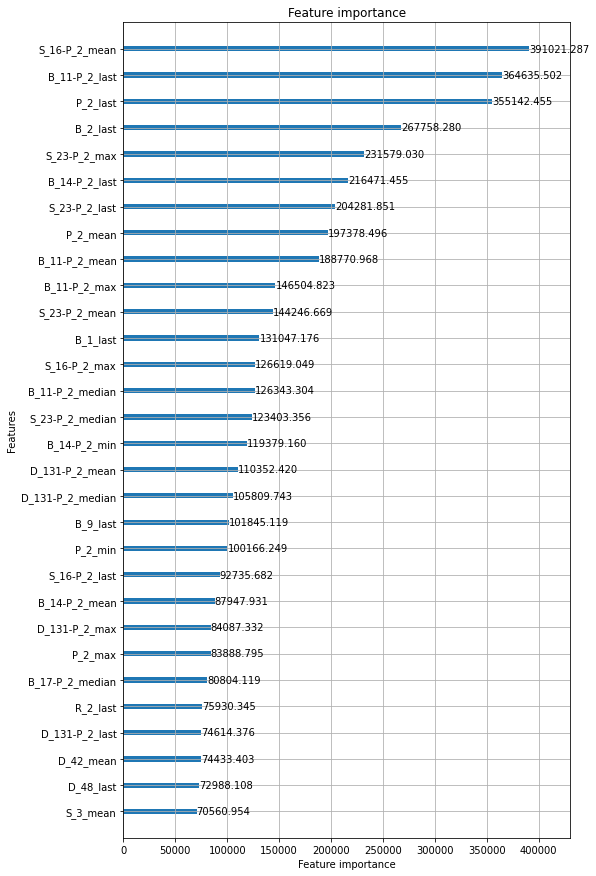

######################################## training model 3/5 ########################################
seed: 2
[50]	valid_0's amex_metric: 0.744223	valid_0's recall_at4: 0.589498	valid_0's norm_gini: 0.898949
[100]	valid_0's amex_metric: 0.749567	valid_0's recall_at4: 0.597787	valid_0's norm_gini: 0.901347
[150]	valid_0's amex_metric: 0.75576	valid_0's recall_at4: 0.607591	valid_0's norm_gini: 0.903928
[200]	valid_0's amex_metric: 0.758536	valid_0's recall_at4: 0.610915	valid_0's norm_gini: 0.906156
[250]	valid_0's amex_metric: 0.759986	valid_0's recall_at4: 0.613103	valid_0's norm_gini: 0.906868
[300]	valid_0's amex_metric: 0.763928	valid_0's recall_at4: 0.618951	valid_0's norm_gini: 0.908905
[350]	valid_0's amex_metric: 0.767265	valid_0's recall_at4: 0.623874	valid_0's norm_gini: 0.910656
[400]	valid_0's amex_metric: 0.770437	valid_0's recall_at4: 0.628713	valid_0's norm_gini: 0.91216
[450]	valid_0's amex_metric: 0.77233	valid_0's recall_at4: 0.631322	valid_0's norm_gini: 0.913338
[500

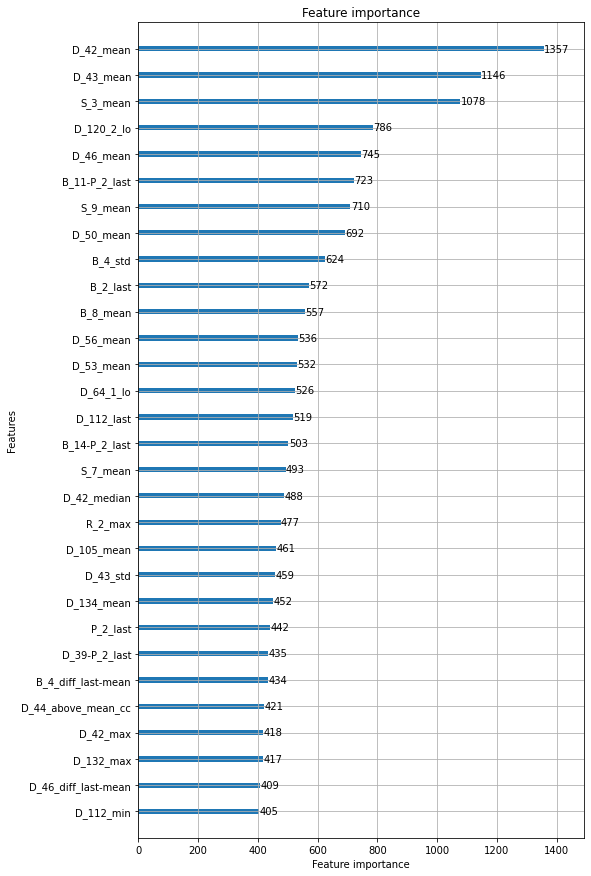

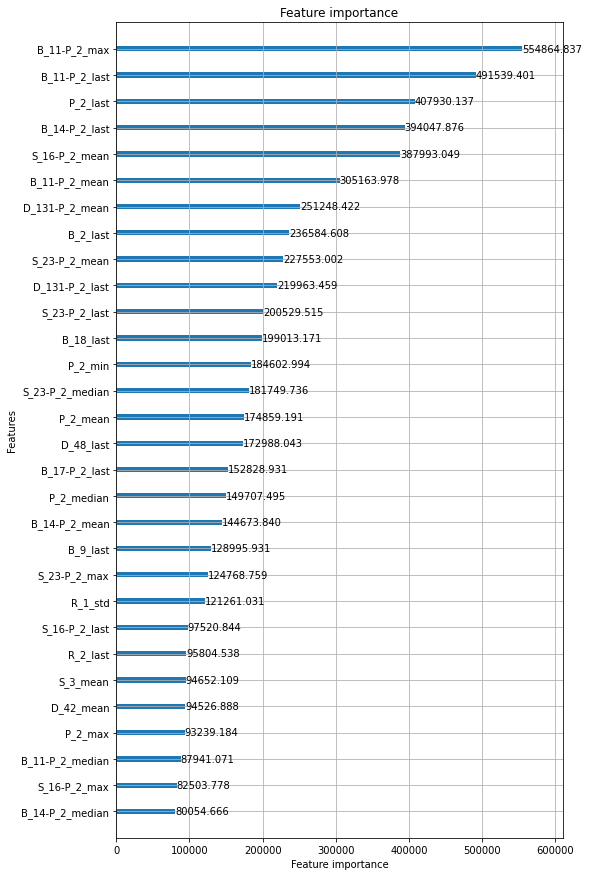

######################################## training model 4/5 ########################################
seed: 3
[50]	valid_0's amex_metric: 0.745949	valid_0's recall_at4: 0.59352	valid_0's norm_gini: 0.898379
[100]	valid_0's amex_metric: 0.751034	valid_0's recall_at4: 0.600126	valid_0's norm_gini: 0.901943
[150]	valid_0's amex_metric: 0.756248	valid_0's recall_at4: 0.607785	valid_0's norm_gini: 0.904712
[200]	valid_0's amex_metric: 0.759854	valid_0's recall_at4: 0.612834	valid_0's norm_gini: 0.906873
[250]	valid_0's amex_metric: 0.765525	valid_0's recall_at4: 0.621839	valid_0's norm_gini: 0.909211
[300]	valid_0's amex_metric: 0.767421	valid_0's recall_at4: 0.623774	valid_0's norm_gini: 0.911067
[350]	valid_0's amex_metric: 0.77134	valid_0's recall_at4: 0.629792	valid_0's norm_gini: 0.912889
[400]	valid_0's amex_metric: 0.774208	valid_0's recall_at4: 0.633915	valid_0's norm_gini: 0.9145
[450]	valid_0's amex_metric: 0.775895	valid_0's recall_at4: 0.636398	valid_0's norm_gini: 0.915391
[500]

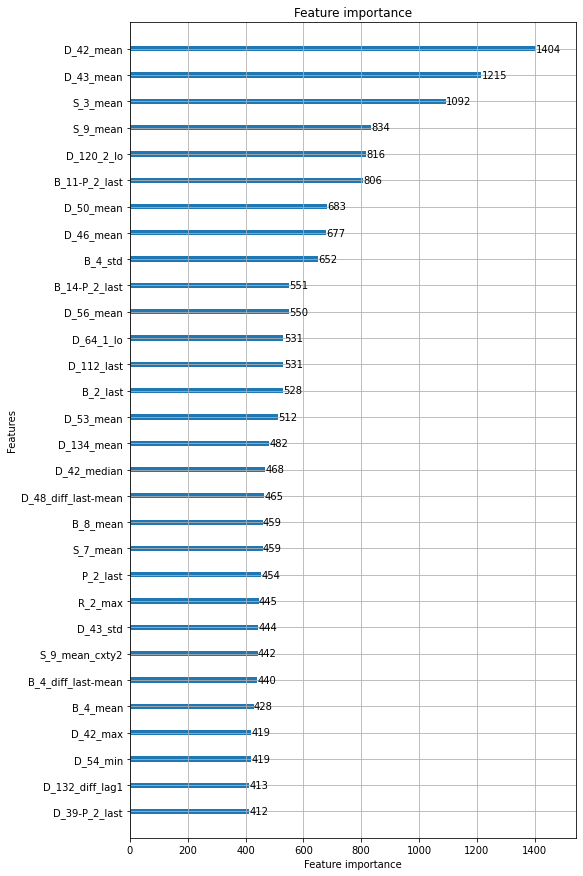

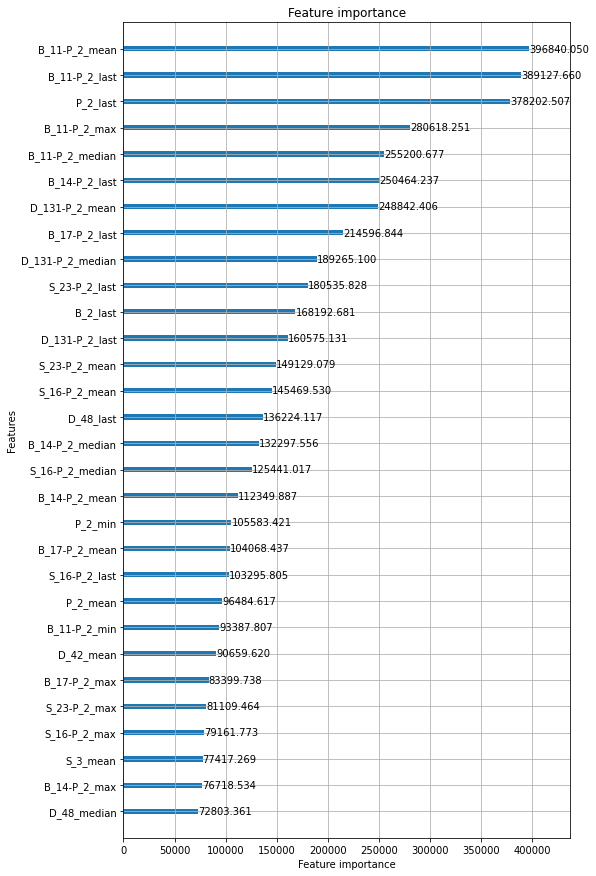

######################################## training model 5/5 ########################################
seed: 4
[50]	valid_0's amex_metric: 0.75338	valid_0's recall_at4: 0.604881	valid_0's norm_gini: 0.901878
[100]	valid_0's amex_metric: 0.758193	valid_0's recall_at4: 0.611824	valid_0's norm_gini: 0.904561
[150]	valid_0's amex_metric: 0.763999	valid_0's recall_at4: 0.620198	valid_0's norm_gini: 0.907799
[200]	valid_0's amex_metric: 0.767781	valid_0's recall_at4: 0.626257	valid_0's norm_gini: 0.909304
[250]	valid_0's amex_metric: 0.772339	valid_0's recall_at4: 0.632737	valid_0's norm_gini: 0.911941
[300]	valid_0's amex_metric: 0.777164	valid_0's recall_at4: 0.639764	valid_0's norm_gini: 0.914563
[350]	valid_0's amex_metric: 0.781604	valid_0's recall_at4: 0.646876	valid_0's norm_gini: 0.916333
[400]	valid_0's amex_metric: 0.782402	valid_0's recall_at4: 0.647928	valid_0's norm_gini: 0.916876
[450]	valid_0's amex_metric: 0.783642	valid_0's recall_at4: 0.649358	valid_0's norm_gini: 0.917925
[5

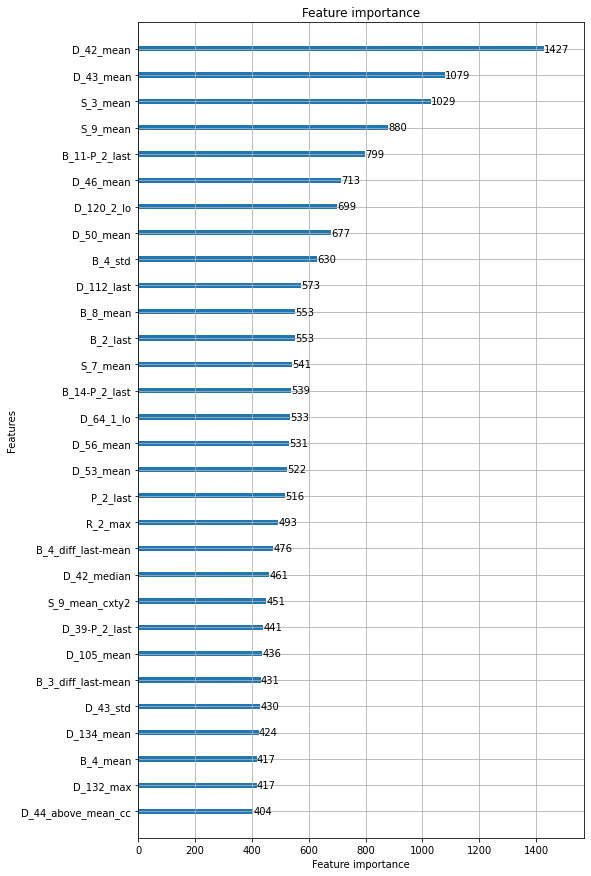

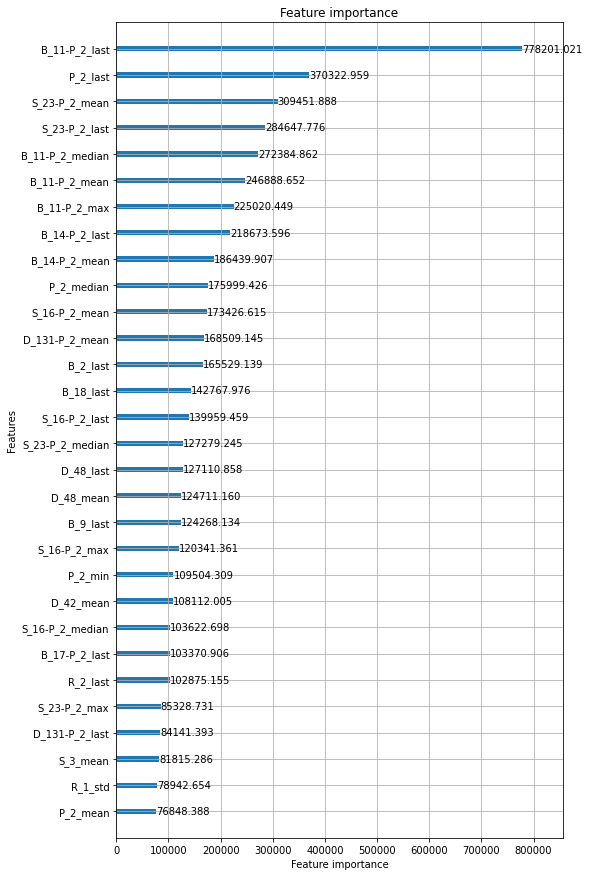

Training time: 84.89596989949544 min.
OOF recall_at4: 0.6692446224795503
OOF normalized_gini: 0.9257129540051221
OOF competition metric: 0.7974787882423362
############################### repeated cross-validation step: 2/5 ################################
######################################## training model 1/5 ########################################
seed: 5
[50]	valid_0's amex_metric: 0.750857	valid_0's recall_at4: 0.600943	valid_0's norm_gini: 0.900772
[100]	valid_0's amex_metric: 0.760551	valid_0's recall_at4: 0.614744	valid_0's norm_gini: 0.906359
[150]	valid_0's amex_metric: 0.765318	valid_0's recall_at4: 0.622486	valid_0's norm_gini: 0.90815
[200]	valid_0's amex_metric: 0.768282	valid_0's recall_at4: 0.626525	valid_0's norm_gini: 0.910039
[250]	valid_0's amex_metric: 0.771432	valid_0's recall_at4: 0.631028	valid_0's norm_gini: 0.911836
[300]	valid_0's amex_metric: 0.775505	valid_0's recall_at4: 0.637297	valid_0's norm_gini: 0.913713
[350]	valid_0's amex_metric: 0.777305	vali

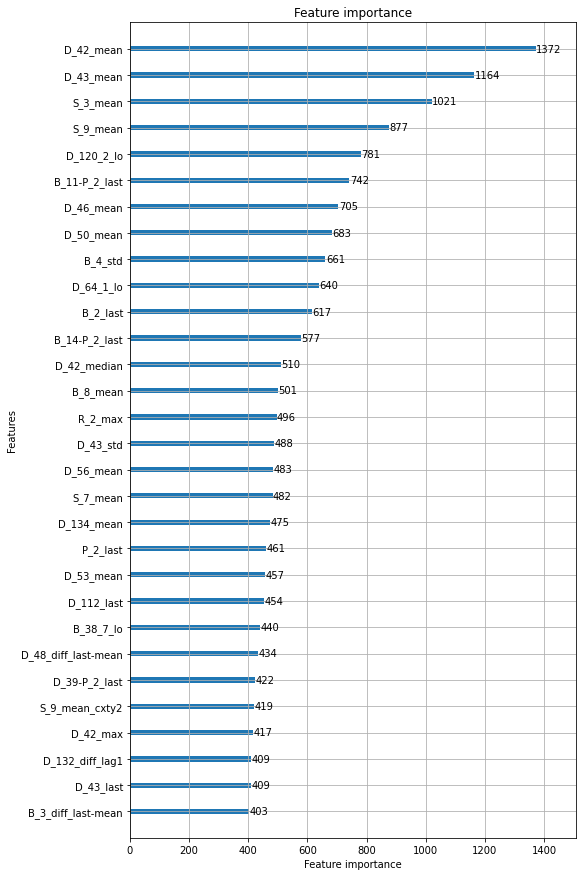

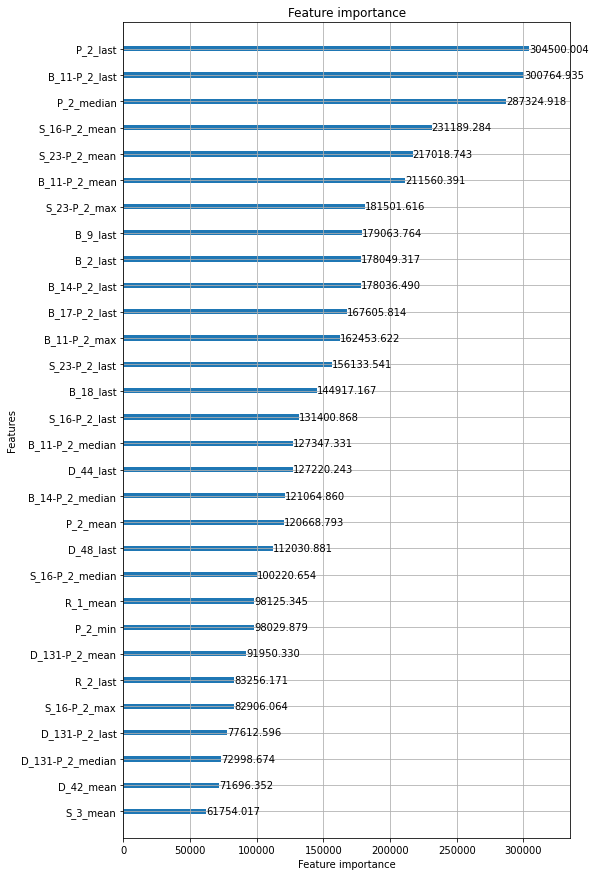

######################################## training model 2/5 ########################################
seed: 6
[50]	valid_0's amex_metric: 0.749074	valid_0's recall_at4: 0.597618	valid_0's norm_gini: 0.90053
[100]	valid_0's amex_metric: 0.756308	valid_0's recall_at4: 0.608811	valid_0's norm_gini: 0.903804
[150]	valid_0's amex_metric: 0.762088	valid_0's recall_at4: 0.616637	valid_0's norm_gini: 0.907538
[200]	valid_0's amex_metric: 0.764249	valid_0's recall_at4: 0.619541	valid_0's norm_gini: 0.908958
[250]	valid_0's amex_metric: 0.766439	valid_0's recall_at4: 0.622276	valid_0's norm_gini: 0.910603
[300]	valid_0's amex_metric: 0.770364	valid_0's recall_at4: 0.628293	valid_0's norm_gini: 0.912436
[350]	valid_0's amex_metric: 0.771871	valid_0's recall_at4: 0.630018	valid_0's norm_gini: 0.913724
[400]	valid_0's amex_metric: 0.772746	valid_0's recall_at4: 0.631364	valid_0's norm_gini: 0.914128
[450]	valid_0's amex_metric: 0.774952	valid_0's recall_at4: 0.634772	valid_0's norm_gini: 0.915132
[5

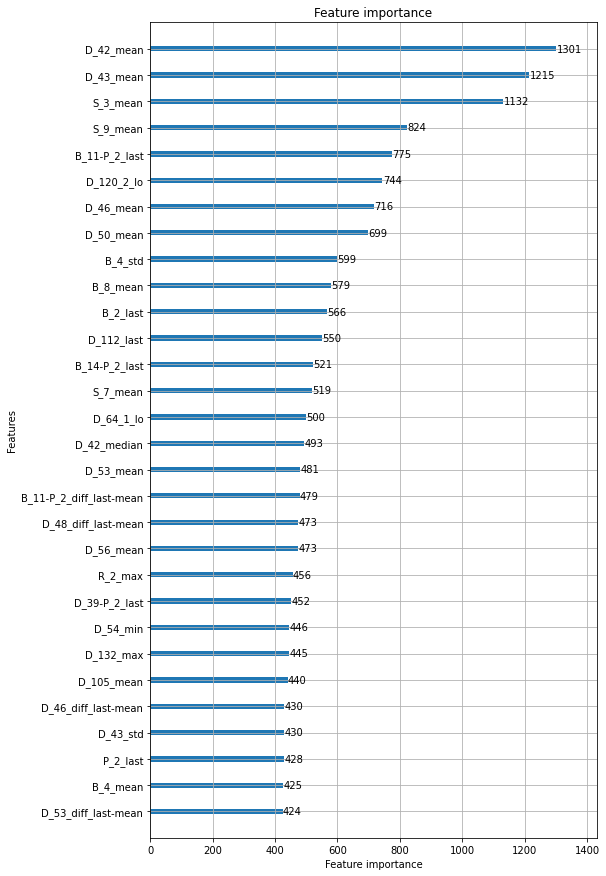

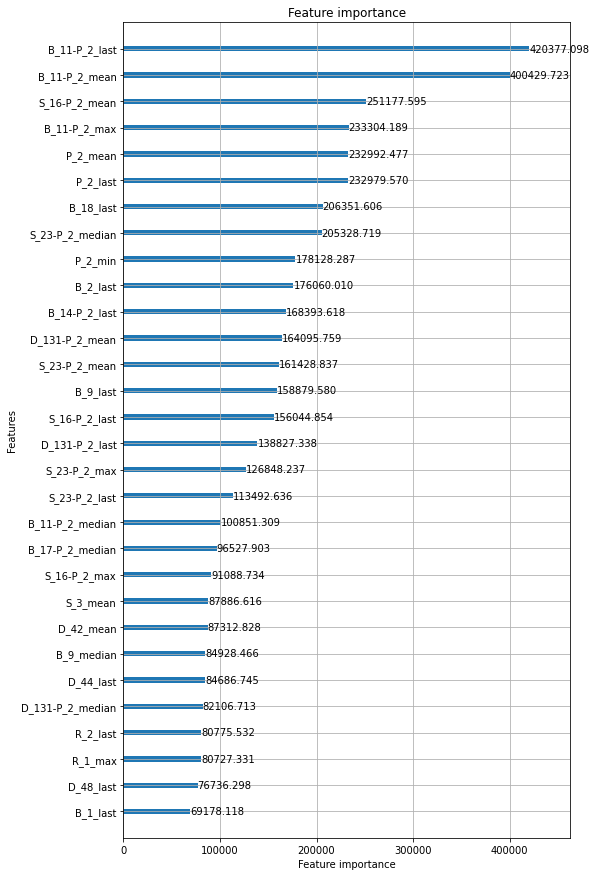

######################################## training model 3/5 ########################################
seed: 7
[50]	valid_0's amex_metric: 0.745267	valid_0's recall_at4: 0.592191	valid_0's norm_gini: 0.898344
[100]	valid_0's amex_metric: 0.750106	valid_0's recall_at4: 0.598502	valid_0's norm_gini: 0.90171
[150]	valid_0's amex_metric: 0.755968	valid_0's recall_at4: 0.606833	valid_0's norm_gini: 0.905102
[200]	valid_0's amex_metric: 0.759573	valid_0's recall_at4: 0.611967	valid_0's norm_gini: 0.907179
[250]	valid_0's amex_metric: 0.763137	valid_0's recall_at4: 0.616974	valid_0's norm_gini: 0.9093
[300]	valid_0's amex_metric: 0.767385	valid_0's recall_at4: 0.623243	valid_0's norm_gini: 0.911526
[350]	valid_0's amex_metric: 0.77001	valid_0's recall_at4: 0.627156	valid_0's norm_gini: 0.912864
[400]	valid_0's amex_metric: 0.770278	valid_0's recall_at4: 0.627156	valid_0's norm_gini: 0.9134
[450]	valid_0's amex_metric: 0.772402	valid_0's recall_at4: 0.630186	valid_0's norm_gini: 0.914617
[500]	v

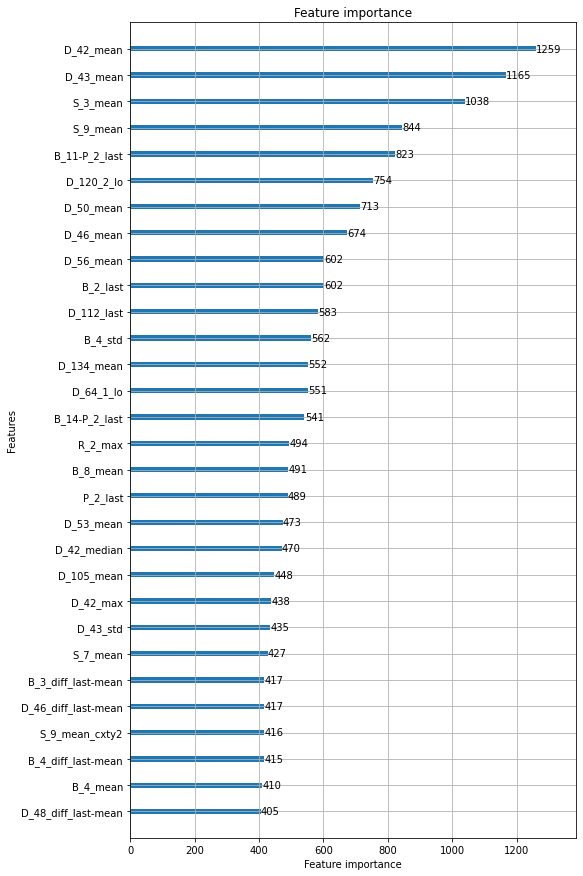

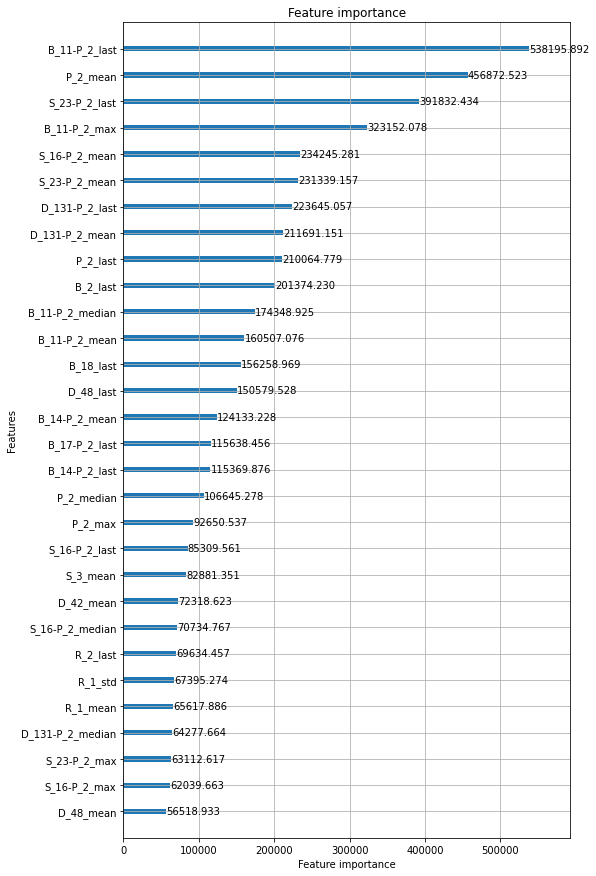

######################################## training model 4/5 ########################################
seed: 8
[50]	valid_0's amex_metric: 0.75187	valid_0's recall_at4: 0.60223	valid_0's norm_gini: 0.90151
[100]	valid_0's amex_metric: 0.758395	valid_0's recall_at4: 0.611698	valid_0's norm_gini: 0.905093
[150]	valid_0's amex_metric: 0.763147	valid_0's recall_at4: 0.619272	valid_0's norm_gini: 0.907021
[200]	valid_0's amex_metric: 0.763906	valid_0's recall_at4: 0.619819	valid_0's norm_gini: 0.907994
[250]	valid_0's amex_metric: 0.765848	valid_0's recall_at4: 0.622723	valid_0's norm_gini: 0.908974
[300]	valid_0's amex_metric: 0.768785	valid_0's recall_at4: 0.627141	valid_0's norm_gini: 0.910429
[350]	valid_0's amex_metric: 0.771962	valid_0's recall_at4: 0.631727	valid_0's norm_gini: 0.912196
[400]	valid_0's amex_metric: 0.773493	valid_0's recall_at4: 0.633831	valid_0's norm_gini: 0.913155
[450]	valid_0's amex_metric: 0.775378	valid_0's recall_at4: 0.636272	valid_0's norm_gini: 0.914485
[500

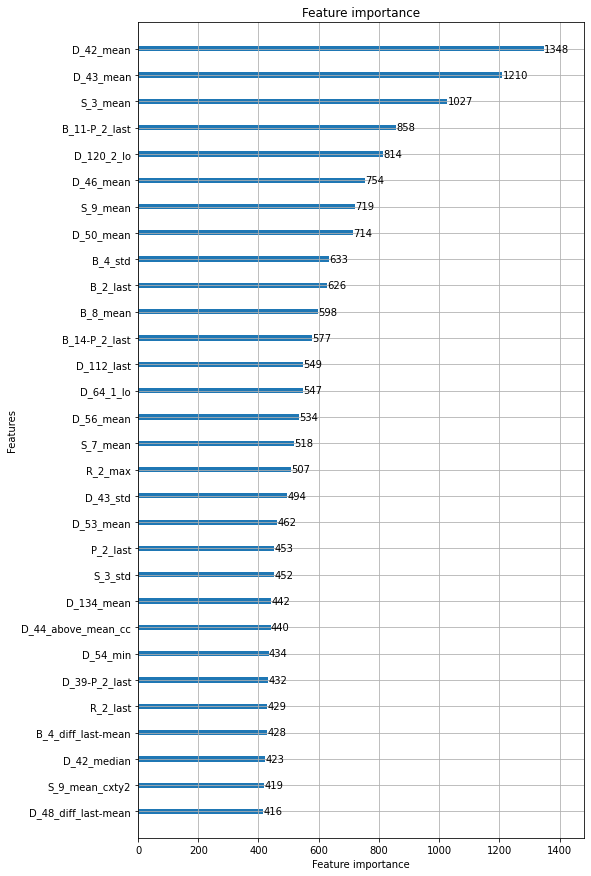

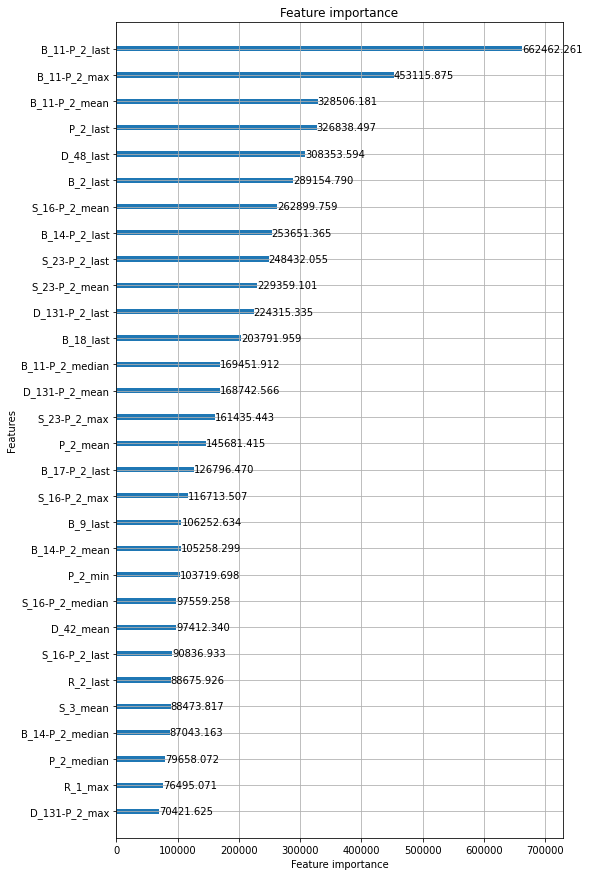

######################################## training model 5/5 ########################################
seed: 9
[50]	valid_0's amex_metric: 0.74894	valid_0's recall_at4: 0.597097	valid_0's norm_gini: 0.900784
[100]	valid_0's amex_metric: 0.755664	valid_0's recall_at4: 0.607322	valid_0's norm_gini: 0.904007
[150]	valid_0's amex_metric: 0.762246	valid_0's recall_at4: 0.617883	valid_0's norm_gini: 0.906608
[200]	valid_0's amex_metric: 0.766356	valid_0's recall_at4: 0.623522	valid_0's norm_gini: 0.909191
[250]	valid_0's amex_metric: 0.770727	valid_0's recall_at4: 0.629708	valid_0's norm_gini: 0.911747
[300]	valid_0's amex_metric: 0.772243	valid_0's recall_at4: 0.632022	valid_0's norm_gini: 0.912464
[350]	valid_0's amex_metric: 0.776363	valid_0's recall_at4: 0.638039	valid_0's norm_gini: 0.914687
[400]	valid_0's amex_metric: 0.778697	valid_0's recall_at4: 0.641574	valid_0's norm_gini: 0.91582
[450]	valid_0's amex_metric: 0.781035	valid_0's recall_at4: 0.645108	valid_0's norm_gini: 0.916961
[50

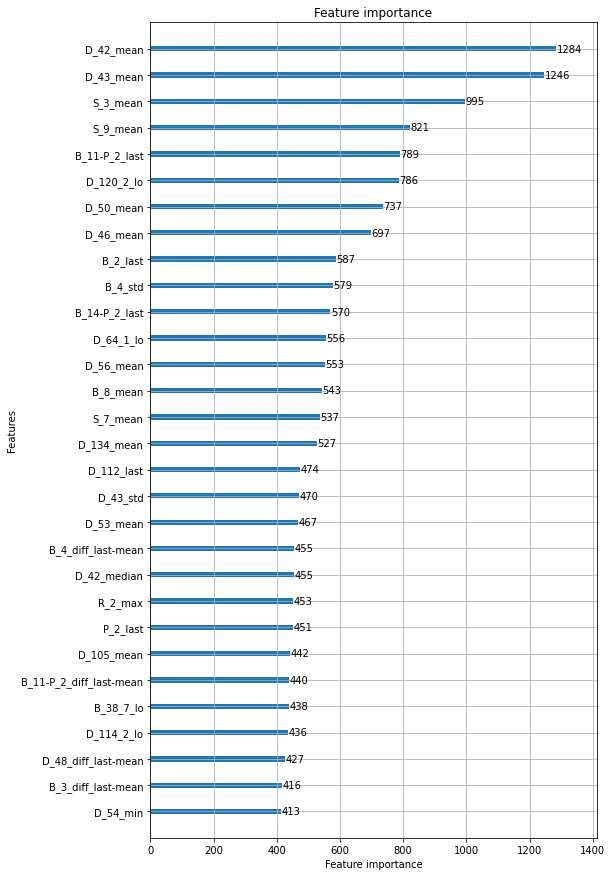

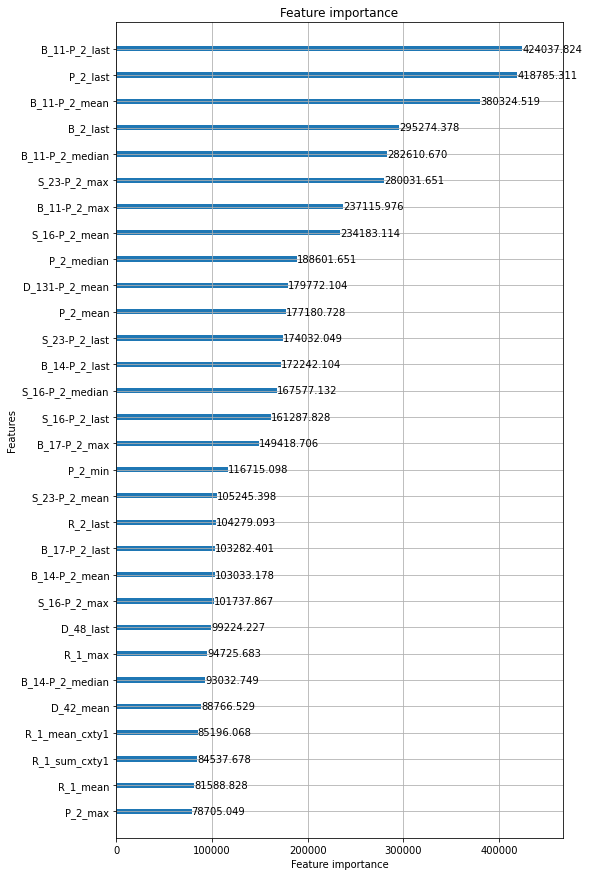

Training time: 84.30505747000376 min.
OOF recall_at4: 0.6701450836503181
OOF normalized_gini: 0.9258162056791788
OOF competition metric: 0.7979806446647484
############################### repeated cross-validation step: 3/5 ################################
######################################## training model 1/5 ########################################
seed: 10
[50]	valid_0's amex_metric: 0.745751	valid_0's recall_at4: 0.592191	valid_0's norm_gini: 0.899312
[100]	valid_0's amex_metric: 0.754501	valid_0's recall_at4: 0.605655	valid_0's norm_gini: 0.903346
[150]	valid_0's amex_metric: 0.756948	valid_0's recall_at4: 0.609105	valid_0's norm_gini: 0.90479
[200]	valid_0's amex_metric: 0.757118	valid_0's recall_at4: 0.608727	valid_0's norm_gini: 0.90551
[250]	valid_0's amex_metric: 0.761145	valid_0's recall_at4: 0.615122	valid_0's norm_gini: 0.907168
[300]	valid_0's amex_metric: 0.763245	valid_0's recall_at4: 0.617815	valid_0's norm_gini: 0.908675
[350]	valid_0's amex_metric: 0.765817	vali

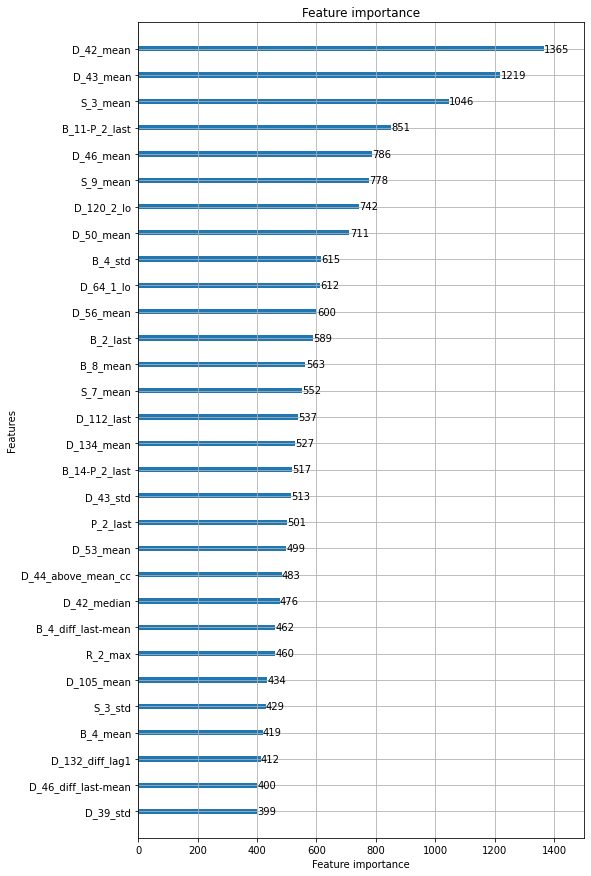

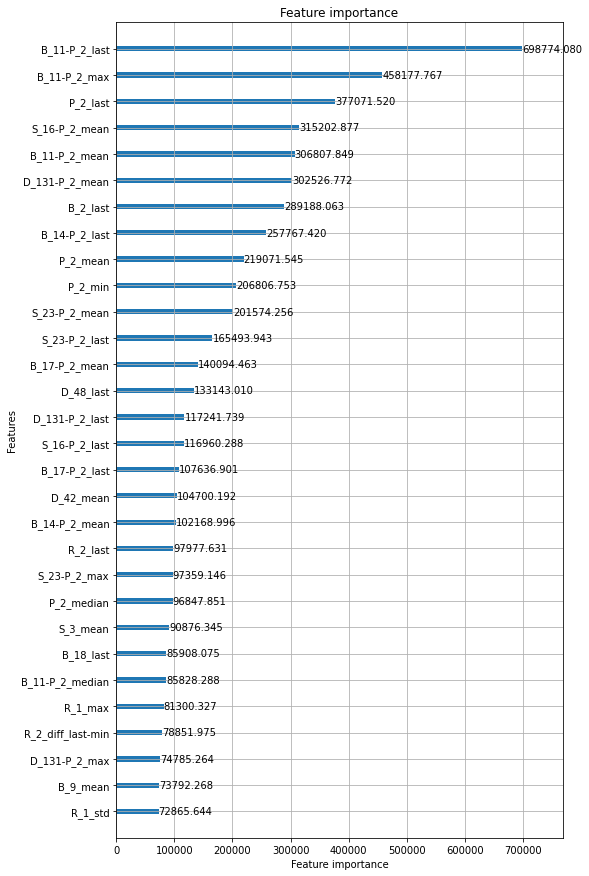

######################################## training model 2/5 ########################################
seed: 11
[50]	valid_0's amex_metric: 0.743261	valid_0's recall_at4: 0.587394	valid_0's norm_gini: 0.899128
[100]	valid_0's amex_metric: 0.751186	valid_0's recall_at4: 0.598586	valid_0's norm_gini: 0.903786
[150]	valid_0's amex_metric: 0.757265	valid_0's recall_at4: 0.608348	valid_0's norm_gini: 0.906182
[200]	valid_0's amex_metric: 0.760664	valid_0's recall_at4: 0.613355	valid_0's norm_gini: 0.907973
[250]	valid_0's amex_metric: 0.76269	valid_0's recall_at4: 0.616216	valid_0's norm_gini: 0.909163
[300]	valid_0's amex_metric: 0.764097	valid_0's recall_at4: 0.618026	valid_0's norm_gini: 0.910167
[350]	valid_0's amex_metric: 0.765907	valid_0's recall_at4: 0.620382	valid_0's norm_gini: 0.911432
[400]	valid_0's amex_metric: 0.768386	valid_0's recall_at4: 0.624169	valid_0's norm_gini: 0.912604
[450]	valid_0's amex_metric: 0.770312	valid_0's recall_at4: 0.626946	valid_0's norm_gini: 0.913677
[

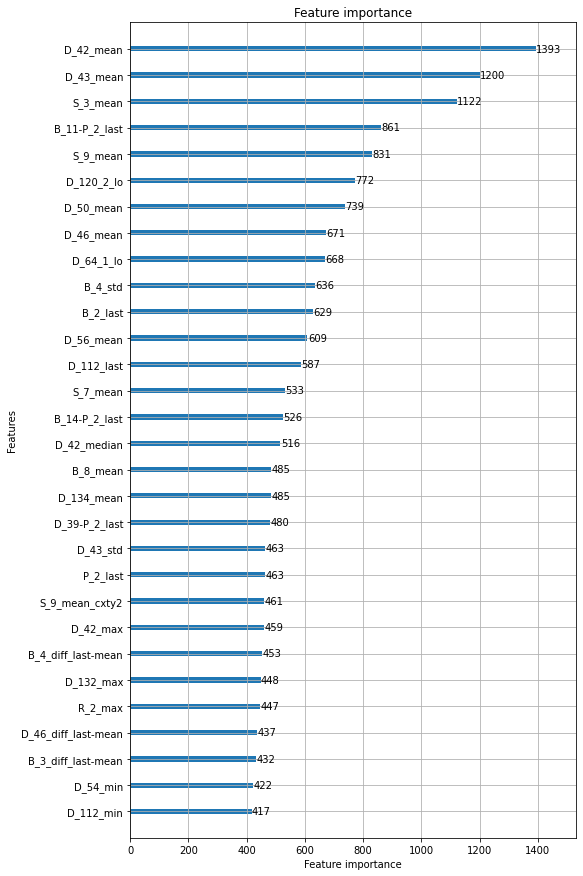

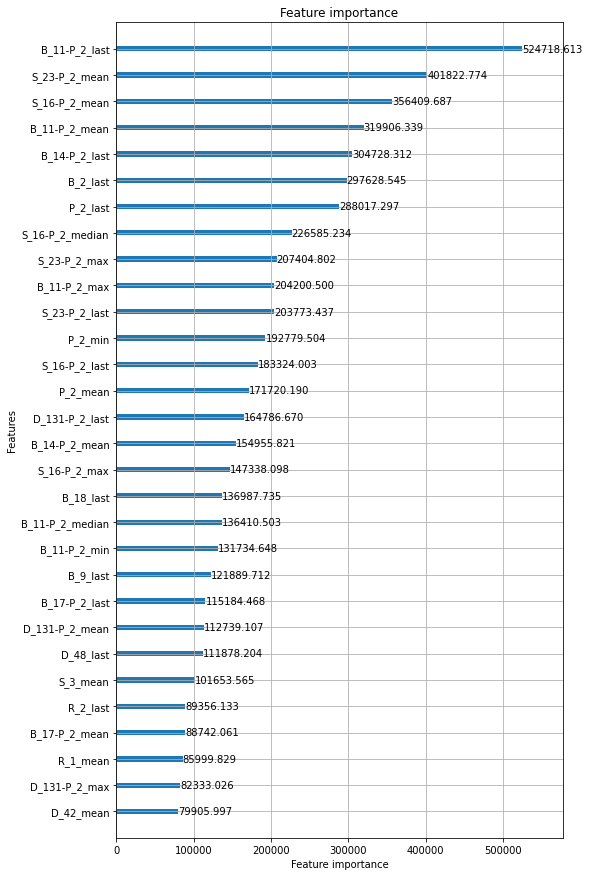

######################################## training model 3/5 ########################################
seed: 12
[50]	valid_0's amex_metric: 0.750841	valid_0's recall_at4: 0.603046	valid_0's norm_gini: 0.898636
[100]	valid_0's amex_metric: 0.757549	valid_0's recall_at4: 0.611883	valid_0's norm_gini: 0.903216
[150]	valid_0's amex_metric: 0.762537	valid_0's recall_at4: 0.620045	valid_0's norm_gini: 0.905029
[200]	valid_0's amex_metric: 0.763847	valid_0's recall_at4: 0.621224	valid_0's norm_gini: 0.90647
[250]	valid_0's amex_metric: 0.766414	valid_0's recall_at4: 0.625179	valid_0's norm_gini: 0.907649
[300]	valid_0's amex_metric: 0.768625	valid_0's recall_at4: 0.627956	valid_0's norm_gini: 0.909293
[350]	valid_0's amex_metric: 0.770654	valid_0's recall_at4: 0.630817	valid_0's norm_gini: 0.910491
[400]	valid_0's amex_metric: 0.775043	valid_0's recall_at4: 0.637171	valid_0's norm_gini: 0.912916
[450]	valid_0's amex_metric: 0.777456	valid_0's recall_at4: 0.640873	valid_0's norm_gini: 0.914038
[

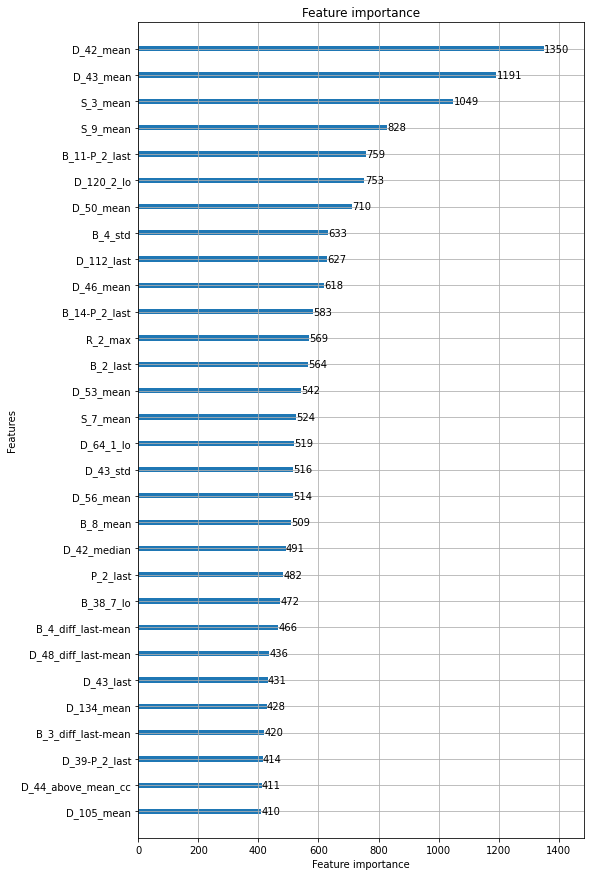

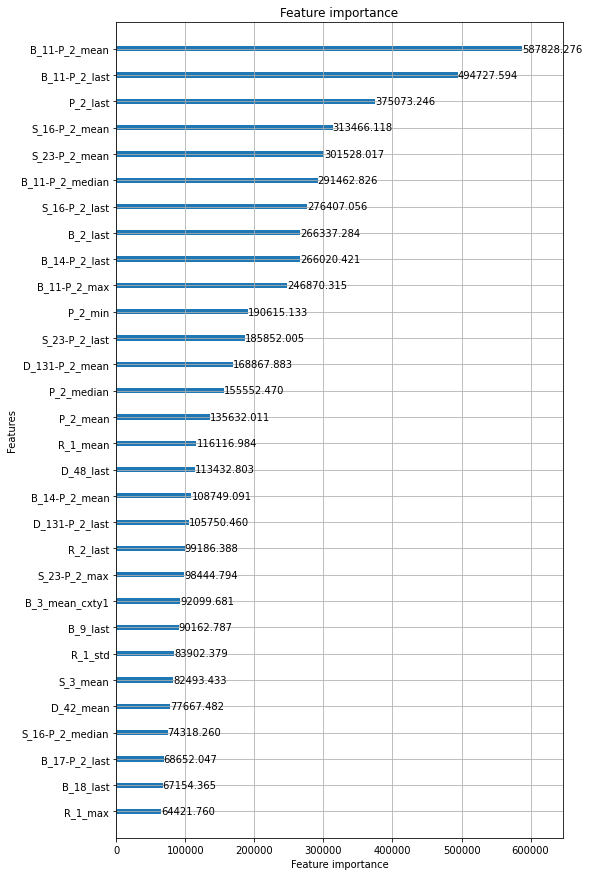

######################################## training model 4/5 ########################################
seed: 13
[50]	valid_0's amex_metric: 0.751685	valid_0's recall_at4: 0.600926	valid_0's norm_gini: 0.902445
[100]	valid_0's amex_metric: 0.75894	valid_0's recall_at4: 0.611488	valid_0's norm_gini: 0.906393
[150]	valid_0's amex_metric: 0.763247	valid_0's recall_at4: 0.617715	valid_0's norm_gini: 0.908778
[200]	valid_0's amex_metric: 0.766892	valid_0's recall_at4: 0.623396	valid_0's norm_gini: 0.910388
[250]	valid_0's amex_metric: 0.77096	valid_0's recall_at4: 0.629497	valid_0's norm_gini: 0.912422
[300]	valid_0's amex_metric: 0.774548	valid_0's recall_at4: 0.634757	valid_0's norm_gini: 0.914339
[350]	valid_0's amex_metric: 0.779519	valid_0's recall_at4: 0.642499	valid_0's norm_gini: 0.916539
[400]	valid_0's amex_metric: 0.781152	valid_0's recall_at4: 0.644688	valid_0's norm_gini: 0.917617
[450]	valid_0's amex_metric: 0.784171	valid_0's recall_at4: 0.649737	valid_0's norm_gini: 0.918604
[5

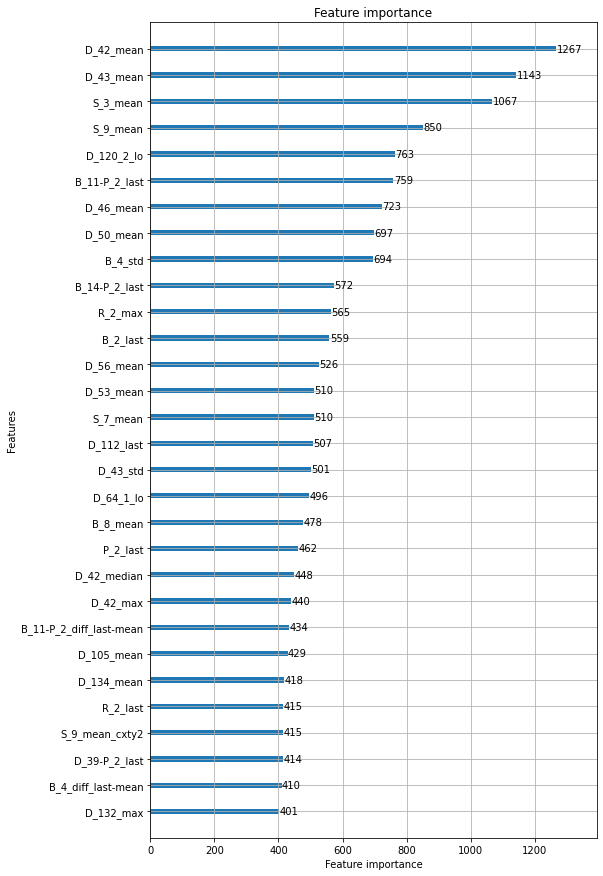

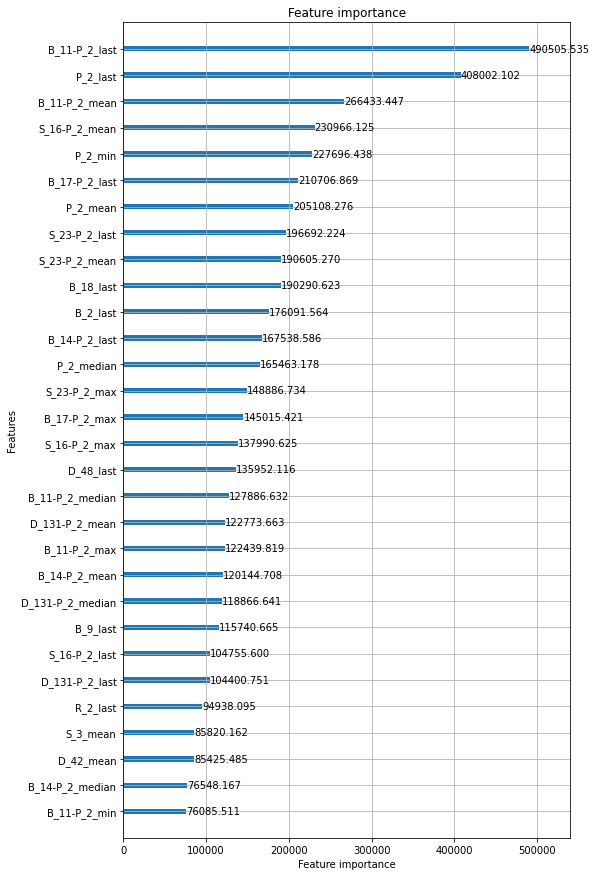

######################################## training model 5/5 ########################################
seed: 14
[50]	valid_0's amex_metric: 0.749589	valid_0's recall_at4: 0.599453	valid_0's norm_gini: 0.899724
[100]	valid_0's amex_metric: 0.757717	valid_0's recall_at4: 0.611277	valid_0's norm_gini: 0.904156
[150]	valid_0's amex_metric: 0.763949	valid_0's recall_at4: 0.619482	valid_0's norm_gini: 0.908416
[200]	valid_0's amex_metric: 0.769552	valid_0's recall_at4: 0.628908	valid_0's norm_gini: 0.910197
[250]	valid_0's amex_metric: 0.77322	valid_0's recall_at4: 0.633621	valid_0's norm_gini: 0.91282
[300]	valid_0's amex_metric: 0.775579	valid_0's recall_at4: 0.63745	valid_0's norm_gini: 0.913708
[350]	valid_0's amex_metric: 0.778087	valid_0's recall_at4: 0.641405	valid_0's norm_gini: 0.914769
[400]	valid_0's amex_metric: 0.778288	valid_0's recall_at4: 0.640943	valid_0's norm_gini: 0.915633
[450]	valid_0's amex_metric: 0.779465	valid_0's recall_at4: 0.64271	valid_0's norm_gini: 0.91622
[500]

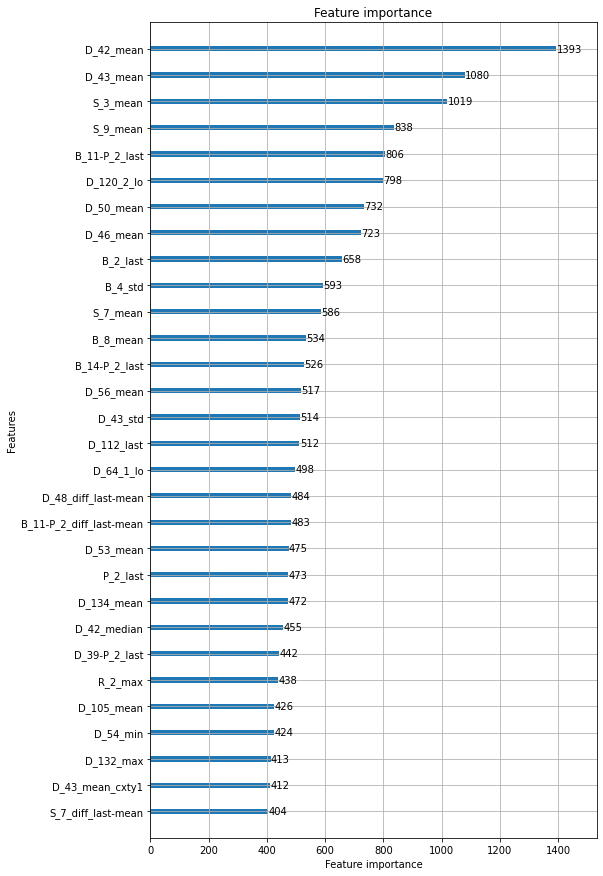

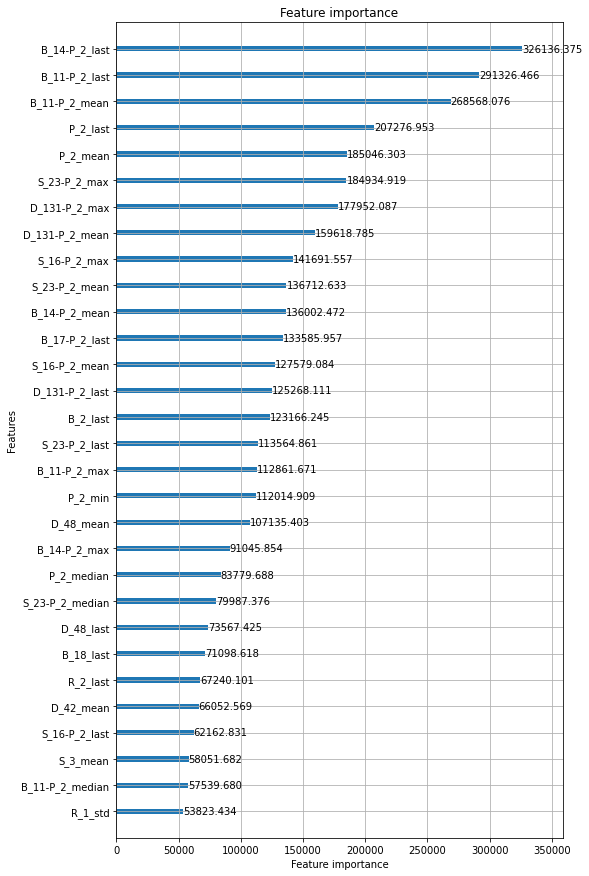

Training time: 85.3562537988027 min.
OOF recall_at4: 0.669842124751742
OOF normalized_gini: 0.9258755009649485
OOF competition metric: 0.7978588128583453
############################### repeated cross-validation step: 4/5 ################################
######################################## training model 1/5 ########################################
seed: 15
[50]	valid_0's amex_metric: 0.749837	valid_0's recall_at4: 0.600985	valid_0's norm_gini: 0.898689
[100]	valid_0's amex_metric: 0.755834	valid_0's recall_at4: 0.609063	valid_0's norm_gini: 0.902604
[150]	valid_0's amex_metric: 0.76308	valid_0's recall_at4: 0.620003	valid_0's norm_gini: 0.906157
[200]	valid_0's amex_metric: 0.765845	valid_0's recall_at4: 0.623959	valid_0's norm_gini: 0.907731
[250]	valid_0's amex_metric: 0.767982	valid_0's recall_at4: 0.626694	valid_0's norm_gini: 0.90927
[300]	valid_0's amex_metric: 0.771648	valid_0's recall_at4: 0.631995	valid_0's norm_gini: 0.911301
[350]	valid_0's amex_metric: 0.773196	valid_

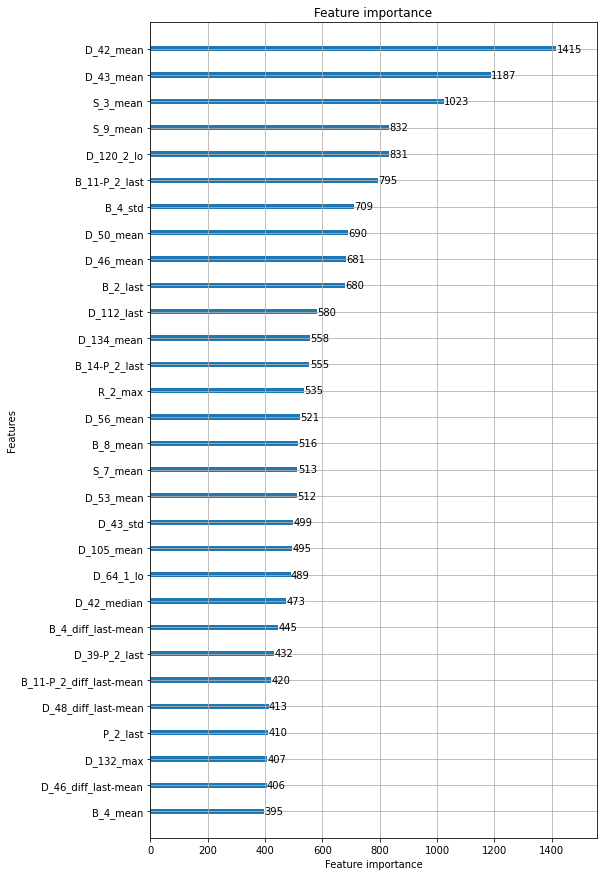

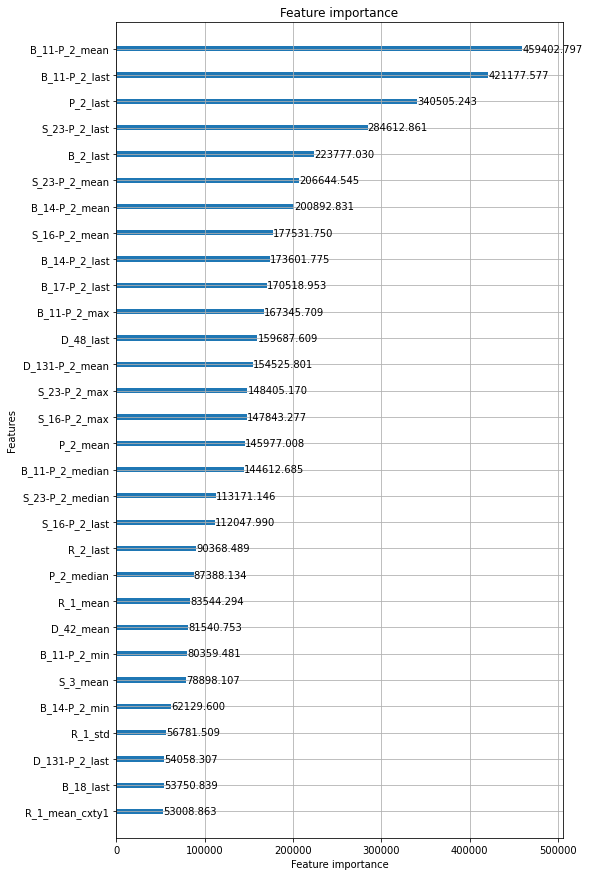

######################################## training model 2/5 ########################################
seed: 16
[50]	valid_0's amex_metric: 0.749213	valid_0's recall_at4: 0.596861	valid_0's norm_gini: 0.901564
[100]	valid_0's amex_metric: 0.755561	valid_0's recall_at4: 0.606749	valid_0's norm_gini: 0.904373
[150]	valid_0's amex_metric: 0.760078	valid_0's recall_at4: 0.612934	valid_0's norm_gini: 0.907221
[200]	valid_0's amex_metric: 0.766621	valid_0's recall_at4: 0.622444	valid_0's norm_gini: 0.910798
[250]	valid_0's amex_metric: 0.771477	valid_0's recall_at4: 0.630565	valid_0's norm_gini: 0.912389
[300]	valid_0's amex_metric: 0.771482	valid_0's recall_at4: 0.629934	valid_0's norm_gini: 0.91303
[350]	valid_0's amex_metric: 0.774905	valid_0's recall_at4: 0.635488	valid_0's norm_gini: 0.914323
[400]	valid_0's amex_metric: 0.777651	valid_0's recall_at4: 0.639317	valid_0's norm_gini: 0.915986
[450]	valid_0's amex_metric: 0.780065	valid_0's recall_at4: 0.64323	valid_0's norm_gini: 0.9169
[500

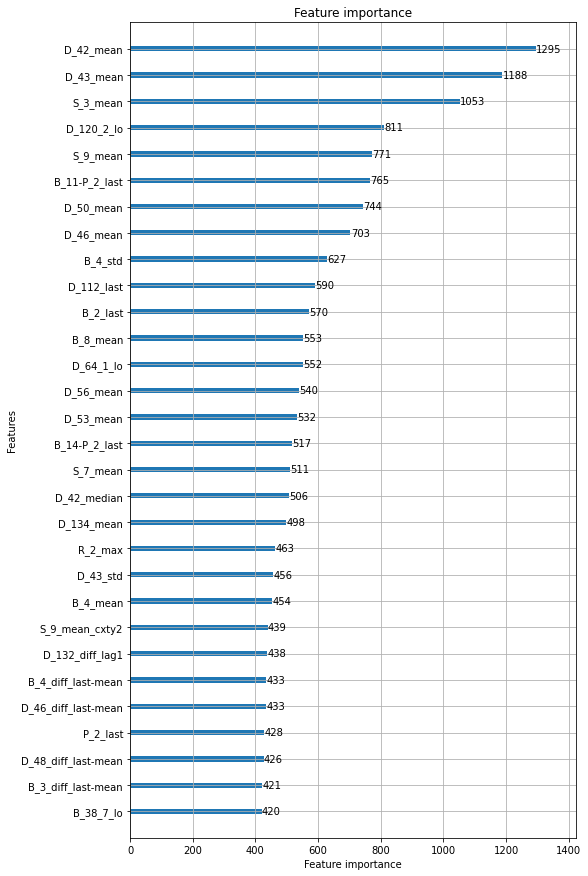

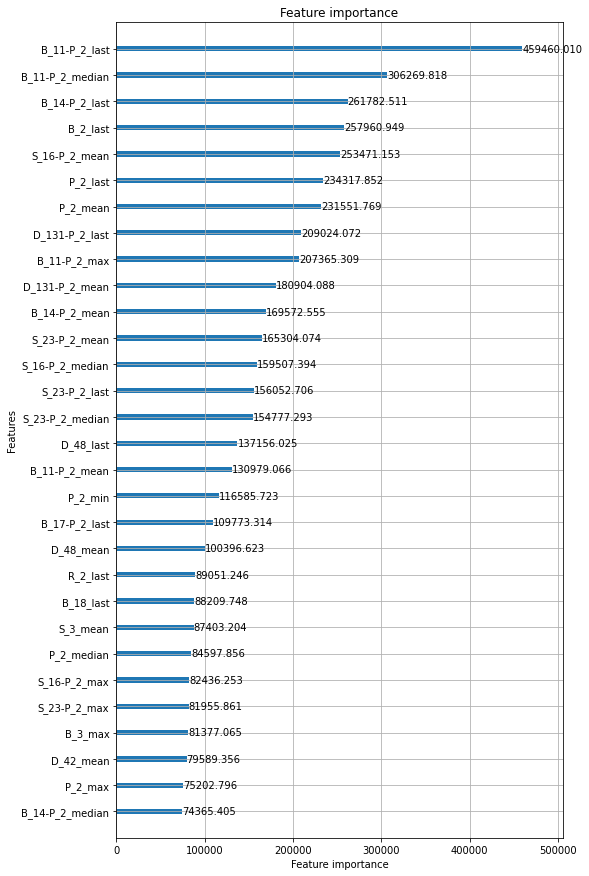

######################################## training model 3/5 ########################################
seed: 17
[50]	valid_0's amex_metric: 0.749716	valid_0's recall_at4: 0.597324	valid_0's norm_gini: 0.902107
[100]	valid_0's amex_metric: 0.758269	valid_0's recall_at4: 0.610578	valid_0's norm_gini: 0.905961
[150]	valid_0's amex_metric: 0.761418	valid_0's recall_at4: 0.615543	valid_0's norm_gini: 0.907294
[200]	valid_0's amex_metric: 0.76674	valid_0's recall_at4: 0.623706	valid_0's norm_gini: 0.909773
[250]	valid_0's amex_metric: 0.769578	valid_0's recall_at4: 0.627577	valid_0's norm_gini: 0.911579
[300]	valid_0's amex_metric: 0.771497	valid_0's recall_at4: 0.630438	valid_0's norm_gini: 0.912555
[350]	valid_0's amex_metric: 0.775048	valid_0's recall_at4: 0.635656	valid_0's norm_gini: 0.914439
[400]	valid_0's amex_metric: 0.776745	valid_0's recall_at4: 0.63797	valid_0's norm_gini: 0.915521
[450]	valid_0's amex_metric: 0.778303	valid_0's recall_at4: 0.640158	valid_0's norm_gini: 0.916447
[5

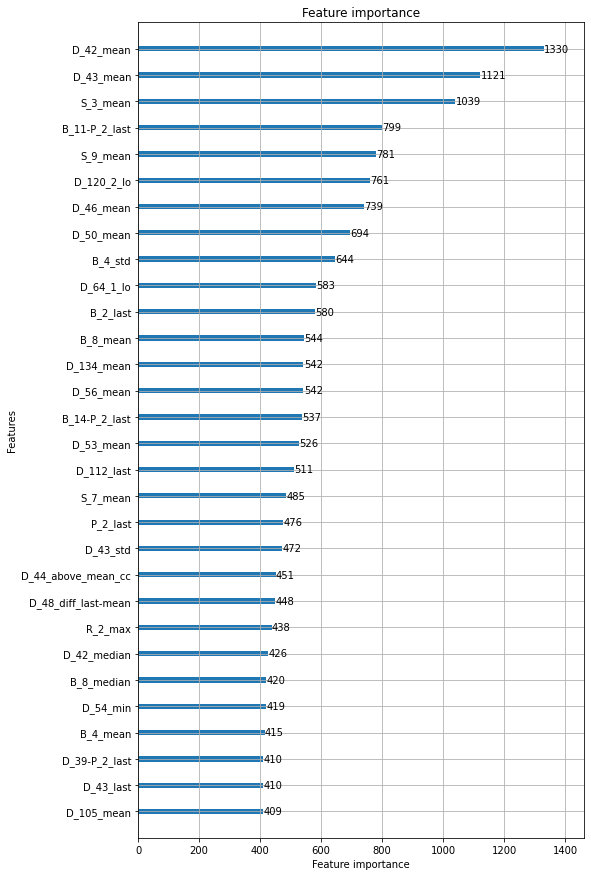

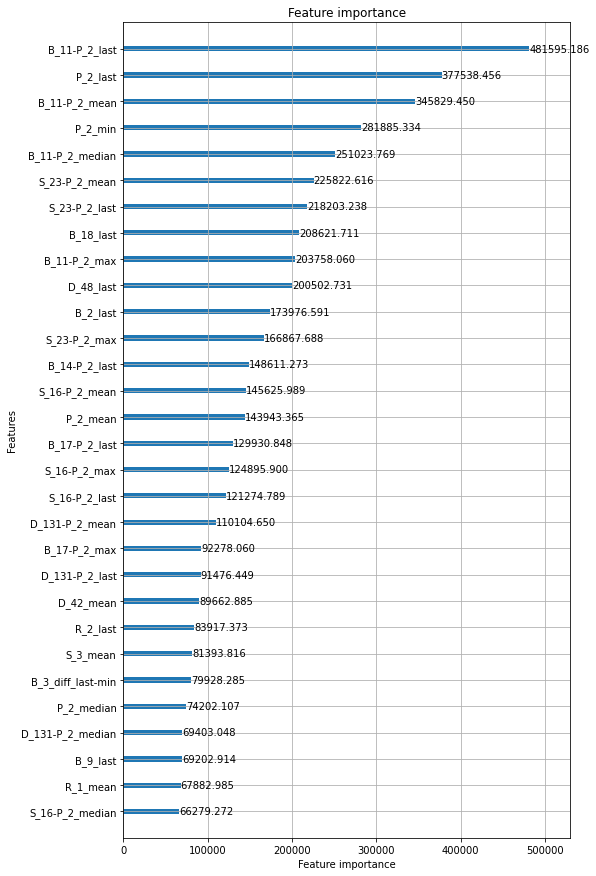

######################################## training model 4/5 ########################################
seed: 18
[50]	valid_0's amex_metric: 0.749196	valid_0's recall_at4: 0.59798	valid_0's norm_gini: 0.900411
[100]	valid_0's amex_metric: 0.758795	valid_0's recall_at4: 0.611908	valid_0's norm_gini: 0.905682
[150]	valid_0's amex_metric: 0.762323	valid_0's recall_at4: 0.617	valid_0's norm_gini: 0.907647
[200]	valid_0's amex_metric: 0.765389	valid_0's recall_at4: 0.621839	valid_0's norm_gini: 0.908939
[250]	valid_0's amex_metric: 0.765143	valid_0's recall_at4: 0.620997	valid_0's norm_gini: 0.909289
[300]	valid_0's amex_metric: 0.76873	valid_0's recall_at4: 0.625963	valid_0's norm_gini: 0.911496
[350]	valid_0's amex_metric: 0.771282	valid_0's recall_at4: 0.629455	valid_0's norm_gini: 0.913109
[400]	valid_0's amex_metric: 0.772974	valid_0's recall_at4: 0.632232	valid_0's norm_gini: 0.913716
[450]	valid_0's amex_metric: 0.774826	valid_0's recall_at4: 0.634925	valid_0's norm_gini: 0.914727
[500]

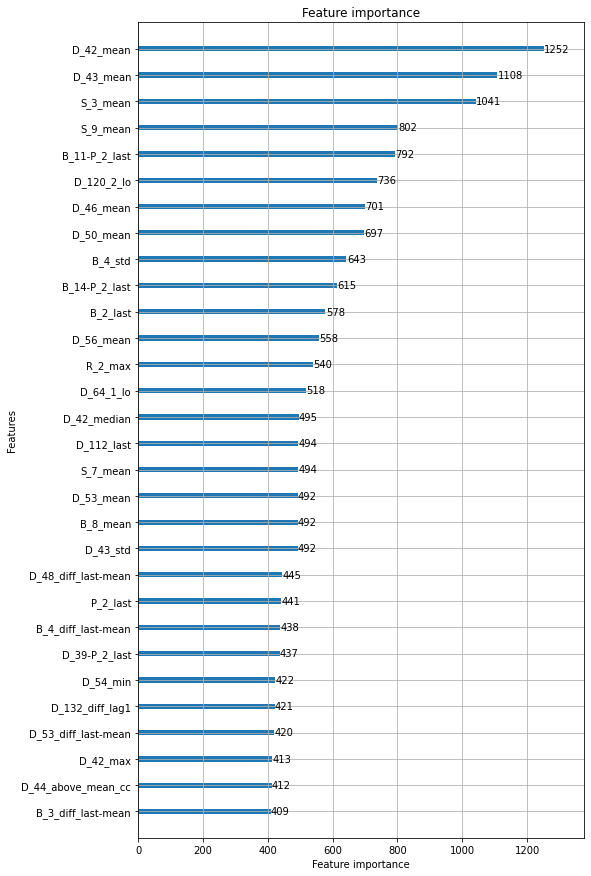

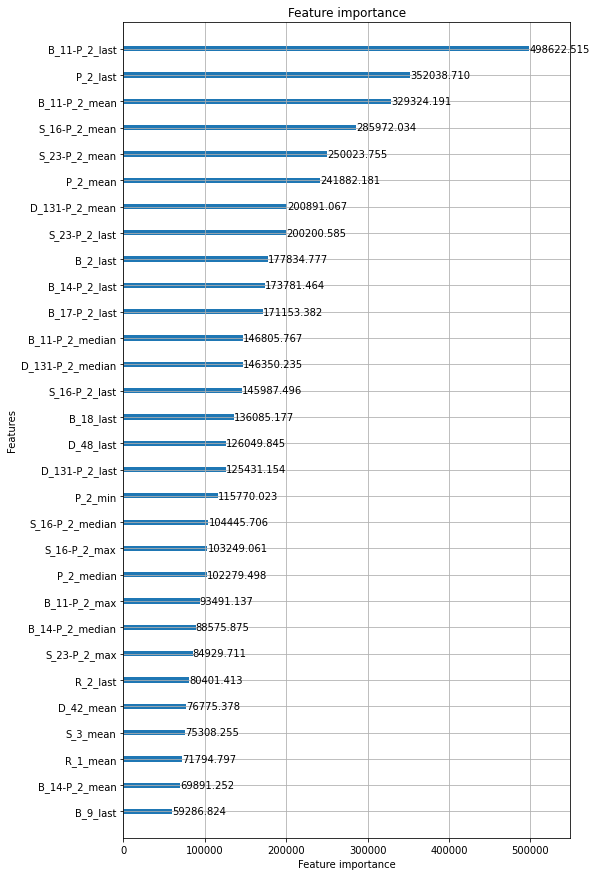

######################################## training model 5/5 ########################################
seed: 19
[50]	valid_0's amex_metric: 0.745701	valid_0's recall_at4: 0.592342	valid_0's norm_gini: 0.89906
[100]	valid_0's amex_metric: 0.750846	valid_0's recall_at4: 0.599369	valid_0's norm_gini: 0.902324
[150]	valid_0's amex_metric: 0.760762	valid_0's recall_at4: 0.614559	valid_0's norm_gini: 0.906966
[200]	valid_0's amex_metric: 0.765425	valid_0's recall_at4: 0.621334	valid_0's norm_gini: 0.909517
[250]	valid_0's amex_metric: 0.76999	valid_0's recall_at4: 0.628066	valid_0's norm_gini: 0.911913
[300]	valid_0's amex_metric: 0.772865	valid_0's recall_at4: 0.632527	valid_0's norm_gini: 0.913203
[350]	valid_0's amex_metric: 0.776007	valid_0's recall_at4: 0.636987	valid_0's norm_gini: 0.915027
[400]	valid_0's amex_metric: 0.777669	valid_0's recall_at4: 0.639133	valid_0's norm_gini: 0.916205
[450]	valid_0's amex_metric: 0.779389	valid_0's recall_at4: 0.641784	valid_0's norm_gini: 0.916994
[5

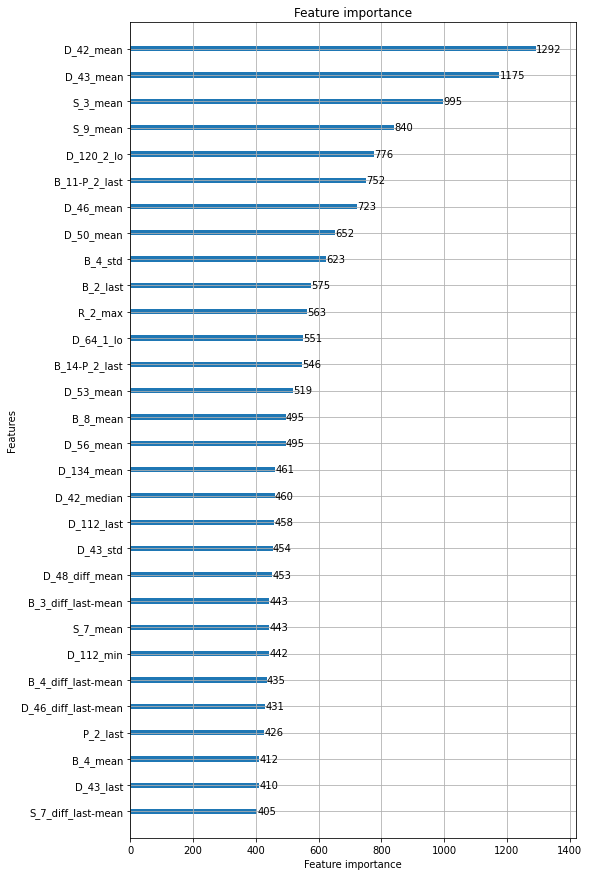

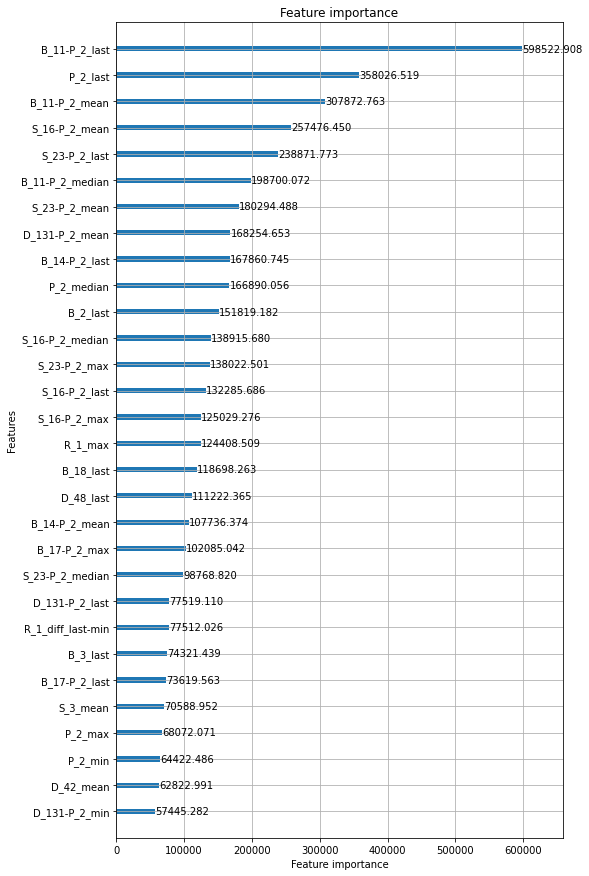

Training time: 84.88850309054057 min.
OOF recall_at4: 0.6702797320496853
OOF normalized_gini: 0.9257760259377353
OOF competition metric: 0.7980278789937103
############################### repeated cross-validation step: 5/5 ################################
######################################## training model 1/5 ########################################
seed: 20
[50]	valid_0's amex_metric: 0.748966	valid_0's recall_at4: 0.597492	valid_0's norm_gini: 0.90044
[100]	valid_0's amex_metric: 0.754984	valid_0's recall_at4: 0.606497	valid_0's norm_gini: 0.903471
[150]	valid_0's amex_metric: 0.762177	valid_0's recall_at4: 0.617058	valid_0's norm_gini: 0.907296
[200]	valid_0's amex_metric: 0.766412	valid_0's recall_at4: 0.622823	valid_0's norm_gini: 0.910001
[250]	valid_0's amex_metric: 0.770936	valid_0's recall_at4: 0.629849	valid_0's norm_gini: 0.912022
[300]	valid_0's amex_metric: 0.775324	valid_0's recall_at4: 0.636582	valid_0's norm_gini: 0.914066
[350]	valid_0's amex_metric: 0.778357	val

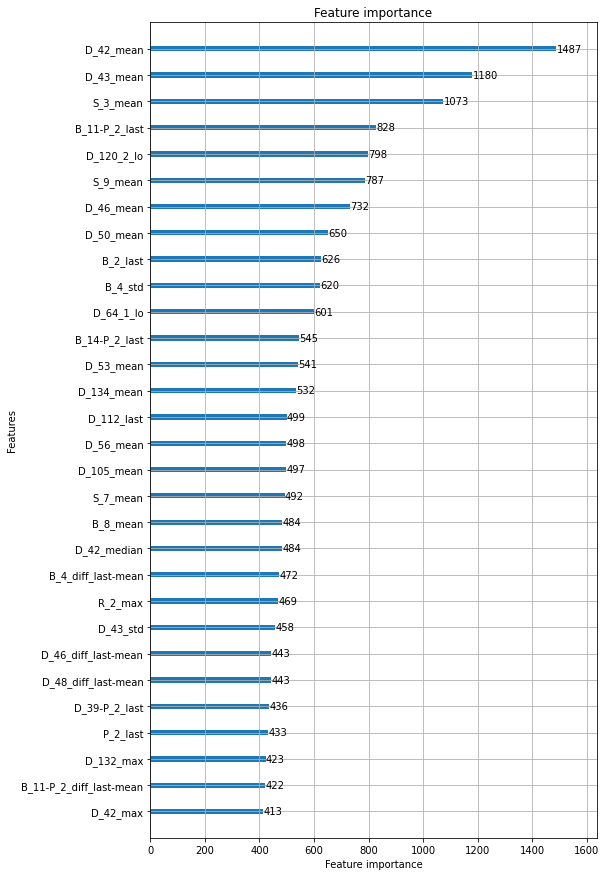

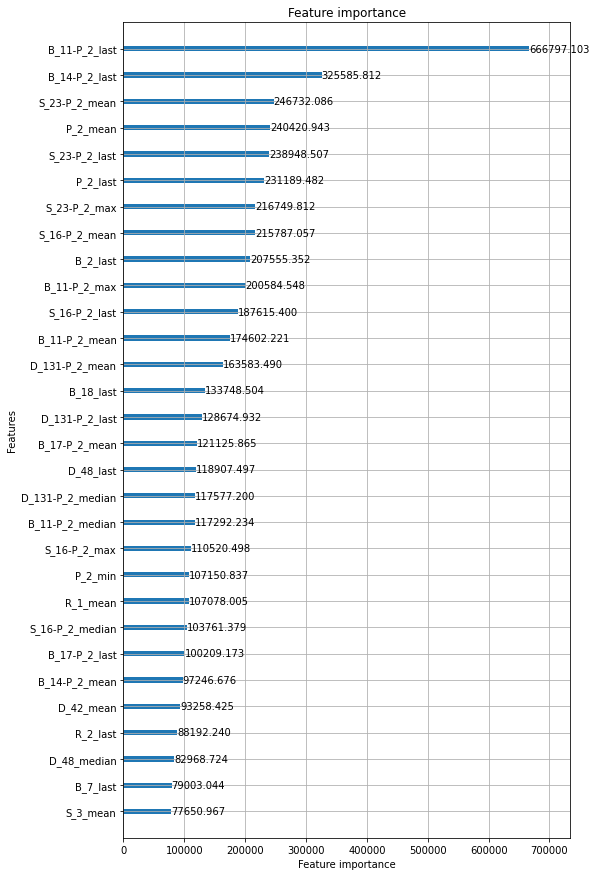

######################################## training model 2/5 ########################################
seed: 21
[50]	valid_0's amex_metric: 0.752291	valid_0's recall_at4: 0.603131	valid_0's norm_gini: 0.901451
[100]	valid_0's amex_metric: 0.760335	valid_0's recall_at4: 0.615207	valid_0's norm_gini: 0.905464
[150]	valid_0's amex_metric: 0.765006	valid_0's recall_at4: 0.622065	valid_0's norm_gini: 0.907947
[200]	valid_0's amex_metric: 0.769382	valid_0's recall_at4: 0.628461	valid_0's norm_gini: 0.910302
[250]	valid_0's amex_metric: 0.774098	valid_0's recall_at4: 0.635067	valid_0's norm_gini: 0.913128
[300]	valid_0's amex_metric: 0.777194	valid_0's recall_at4: 0.639653	valid_0's norm_gini: 0.914735
[350]	valid_0's amex_metric: 0.781646	valid_0's recall_at4: 0.646764	valid_0's norm_gini: 0.916528
[400]	valid_0's amex_metric: 0.783703	valid_0's recall_at4: 0.649583	valid_0's norm_gini: 0.917823
[450]	valid_0's amex_metric: 0.784274	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.918207


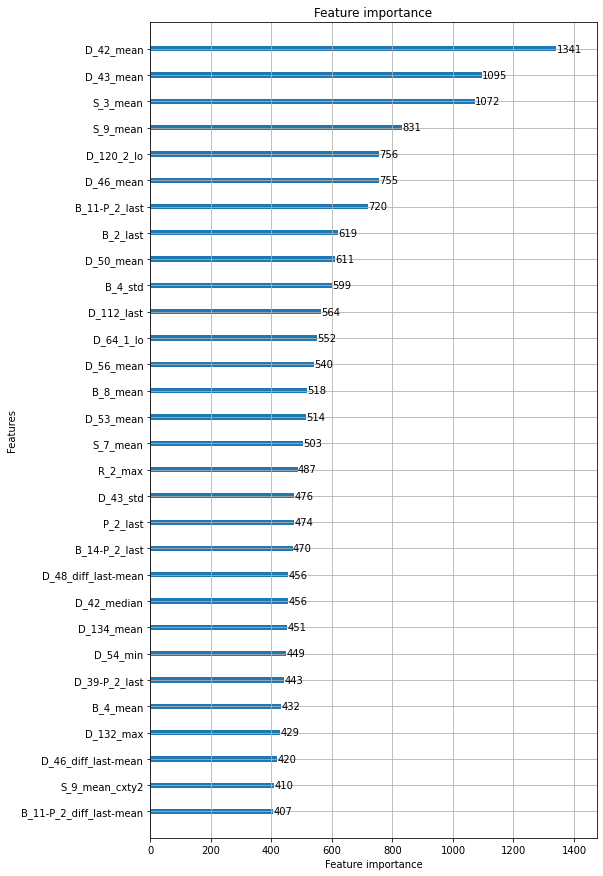

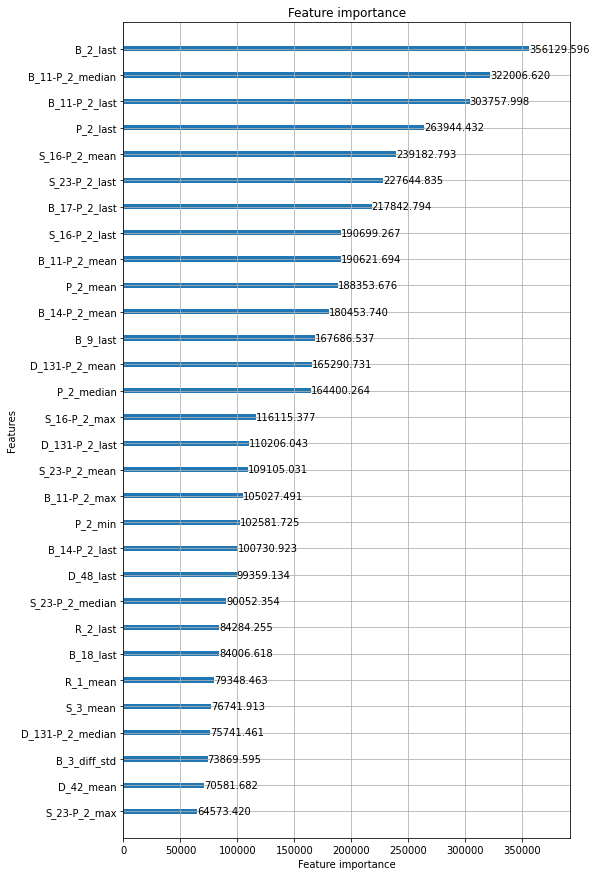

######################################## training model 3/5 ########################################
seed: 22
[50]	valid_0's amex_metric: 0.747371	valid_0's recall_at4: 0.594631	valid_0's norm_gini: 0.900111
[100]	valid_0's amex_metric: 0.750775	valid_0's recall_at4: 0.599049	valid_0's norm_gini: 0.9025
[150]	valid_0's amex_metric: 0.755614	valid_0's recall_at4: 0.606665	valid_0's norm_gini: 0.904563
[200]	valid_0's amex_metric: 0.759696	valid_0's recall_at4: 0.612303	valid_0's norm_gini: 0.907088
[250]	valid_0's amex_metric: 0.765219	valid_0's recall_at4: 0.620887	valid_0's norm_gini: 0.909551
[300]	valid_0's amex_metric: 0.769562	valid_0's recall_at4: 0.62703	valid_0's norm_gini: 0.912094
[350]	valid_0's amex_metric: 0.771981	valid_0's recall_at4: 0.630481	valid_0's norm_gini: 0.913481
[400]	valid_0's amex_metric: 0.774168	valid_0's recall_at4: 0.633636	valid_0's norm_gini: 0.914699
[450]	valid_0's amex_metric: 0.775414	valid_0's recall_at4: 0.635361	valid_0's norm_gini: 0.915467
[50

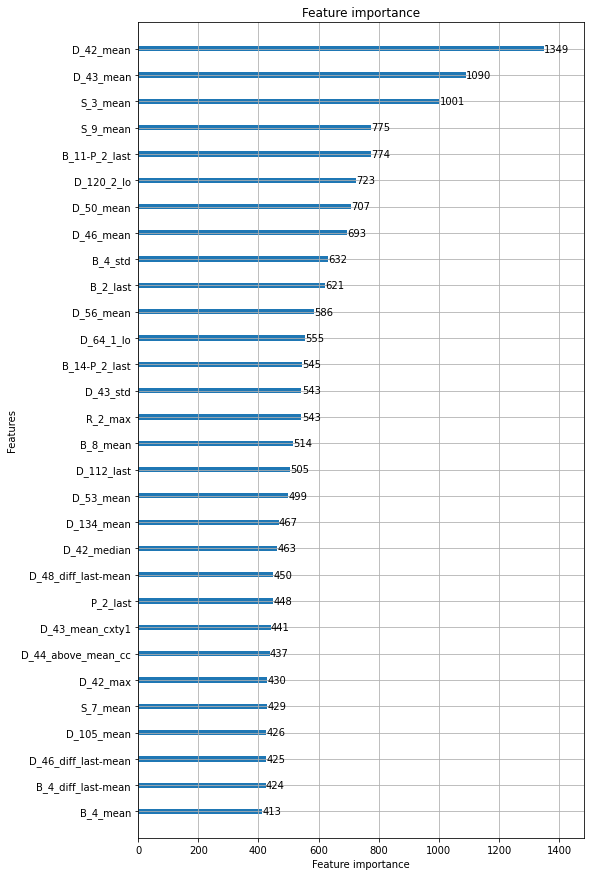

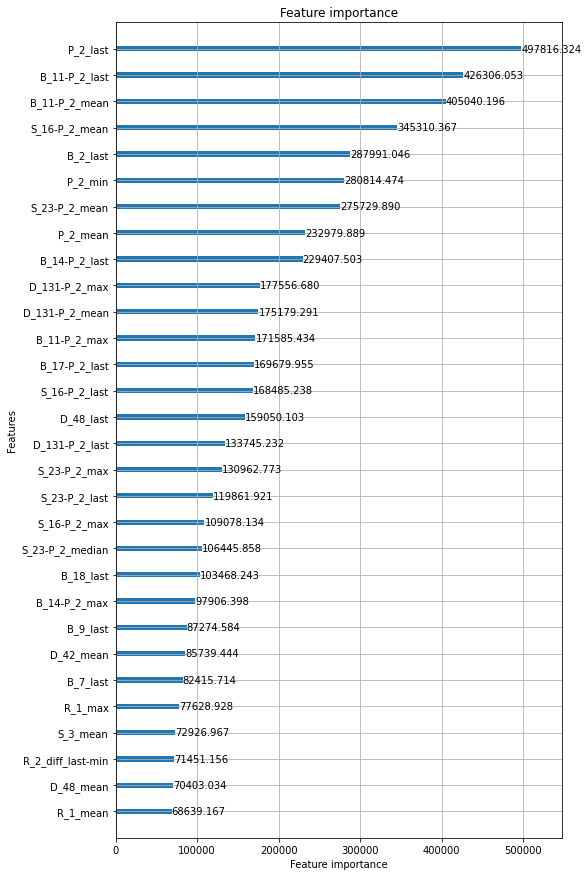

######################################## training model 4/5 ########################################
seed: 23
[50]	valid_0's amex_metric: 0.746138	valid_0's recall_at4: 0.592468	valid_0's norm_gini: 0.899808
[100]	valid_0's amex_metric: 0.759748	valid_0's recall_at4: 0.613381	valid_0's norm_gini: 0.906116
[150]	valid_0's amex_metric: 0.762978	valid_0's recall_at4: 0.618052	valid_0's norm_gini: 0.907905
[200]	valid_0's amex_metric: 0.767507	valid_0's recall_at4: 0.624995	valid_0's norm_gini: 0.910019
[250]	valid_0's amex_metric: 0.769248	valid_0's recall_at4: 0.627183	valid_0's norm_gini: 0.911314
[300]	valid_0's amex_metric: 0.769882	valid_0's recall_at4: 0.628024	valid_0's norm_gini: 0.91174
[350]	valid_0's amex_metric: 0.772727	valid_0's recall_at4: 0.632064	valid_0's norm_gini: 0.913389
[400]	valid_0's amex_metric: 0.774103	valid_0's recall_at4: 0.633705	valid_0's norm_gini: 0.9145
[450]	valid_0's amex_metric: 0.775847	valid_0's recall_at4: 0.636398	valid_0's norm_gini: 0.915296
[50

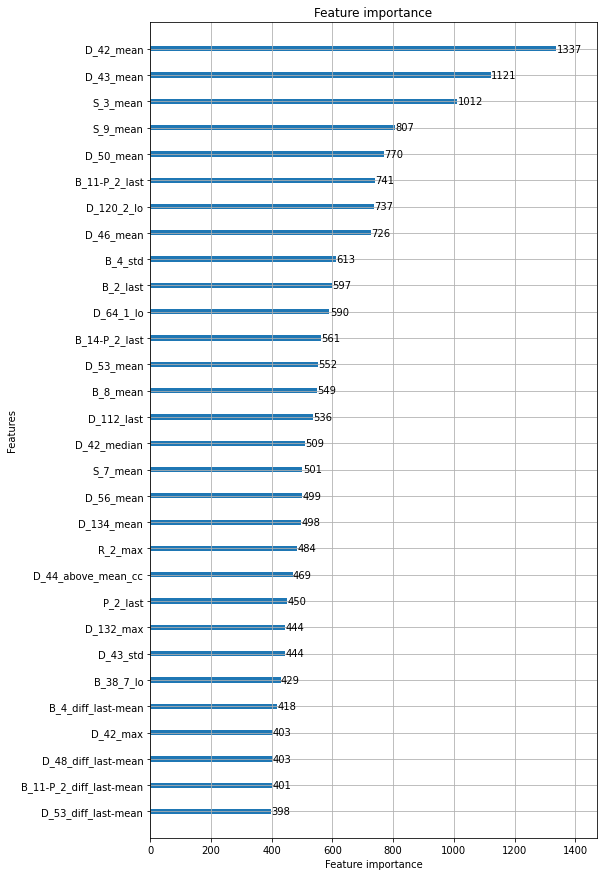

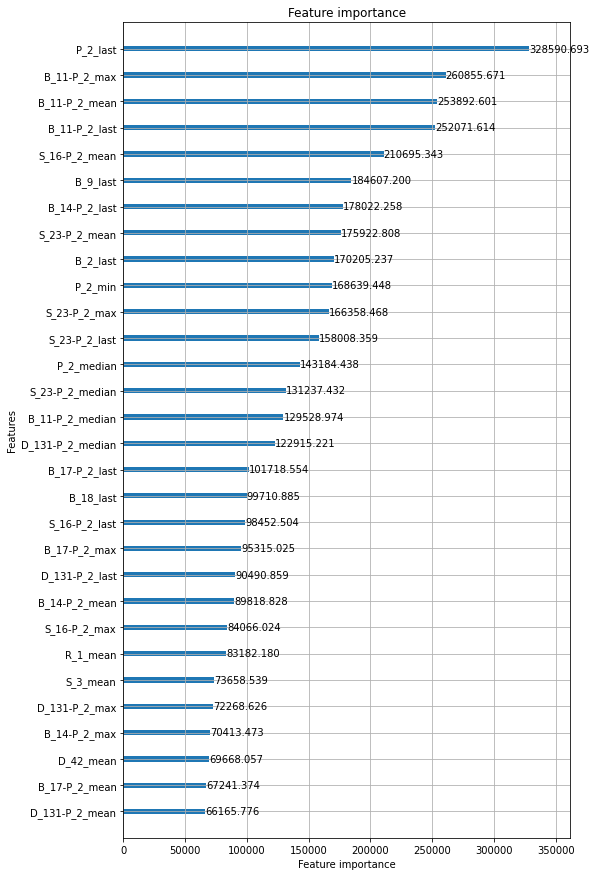

######################################## training model 5/5 ########################################
seed: 24
[50]	valid_0's amex_metric: 0.748819	valid_0's recall_at4: 0.598527	valid_0's norm_gini: 0.89911
[100]	valid_0's amex_metric: 0.756876	valid_0's recall_at4: 0.609594	valid_0's norm_gini: 0.904159
[150]	valid_0's amex_metric: 0.760601	valid_0's recall_at4: 0.614559	valid_0's norm_gini: 0.906643
[200]	valid_0's amex_metric: 0.763535	valid_0's recall_at4: 0.618304	valid_0's norm_gini: 0.908765
[250]	valid_0's amex_metric: 0.766114	valid_0's recall_at4: 0.62226	valid_0's norm_gini: 0.909968
[300]	valid_0's amex_metric: 0.769304	valid_0's recall_at4: 0.627141	valid_0's norm_gini: 0.911468
[350]	valid_0's amex_metric: 0.772283	valid_0's recall_at4: 0.631601	valid_0's norm_gini: 0.912966
[400]	valid_0's amex_metric: 0.772813	valid_0's recall_at4: 0.631896	valid_0's norm_gini: 0.91373
[450]	valid_0's amex_metric: 0.775552	valid_0's recall_at4: 0.636146	valid_0's norm_gini: 0.914959
[50

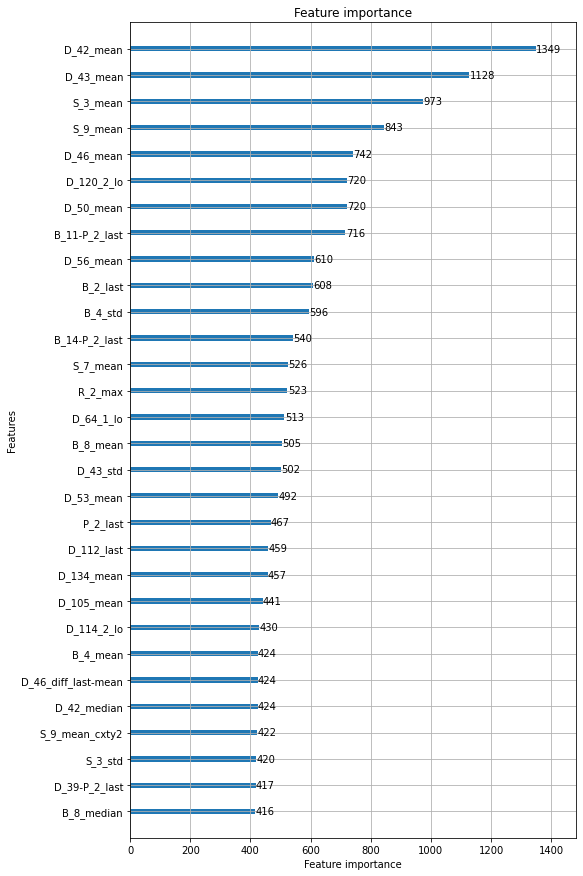

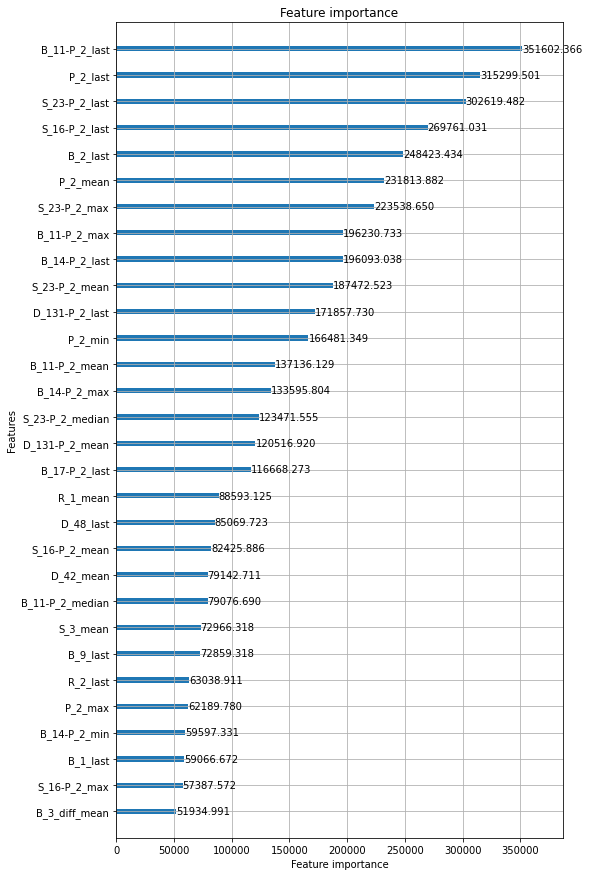

Training time: 85.70787659088771 min.
OOF recall_at4: 0.6699346955263069
OOF normalized_gini: 0.9258250853771866
OOF competition metric: 0.7978798904517468
CPU times: user 6d 1h 48min 3s, sys: 4min 8s, total: 6d 1h 52min 12s
Wall time: 7h 5min 33s


In [12]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
        
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [13]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

recall_at4      gini    metric
0    0.669245  0.925713  0.797479
1    0.670145  0.925816  0.797981
2    0.669842  0.925876  0.797859
3    0.670280  0.925776  0.798028
4    0.669935  0.925825  0.797880


mean:


recall_at4    0.669889
gini          0.925801
metric        0.797845
dtype: float64


std:


recall_at4    0.000399
gini          0.000061
metric        0.000216
dtype: float64

In [14]:
del train, all_oof_dfs
gc.collect()

21

***
## make predictions and submit

In [15]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)       

In [16]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [17]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 4h 29min 20s, sys: 1min 20s, total: 4h 30min 40s
Wall time: 14min 40s


In [18]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.53 s, sys: 779 ms, total: 4.31 s
Wall time: 4.61 s


***